In [ ]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
# !pip install seaborn

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


## Setings

In [1]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2

from modules.gnn_models import GCN, GraphSAGE, GAT
from modules.graph import Graph, create_files
from modules.gnn import GNN
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import numpy as np

# from modules.gnn import GNN
# from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
# from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces

# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.metrics import (
    confusion_matrix,              # ya lo estabas usando
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)
# from utils import *
# from modules.graph import Graph
# import numpy as np
import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from bgp2vec.bgp2vec import BGP2VEC


print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [2]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}



In [3]:
# Definimos las rutas de los archivos
BASE_PROJECT_PATH = os.getcwd() + "/data/"
RELATIONSHIPS_FILE  = BASE_PROJECT_PATH + "CAIDA_AS_Relationships/Serial_1/20220701.as-rel.txt.bz2"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_feature_mio.csv" #"/node_features.csv" 
rib_path = BASE_PROJECT_PATH + 'sanitized_rib.txt'
MES = 'febrero'
dataset_graph_path = BASE_PROJECT_PATH + f'dgl_graph/{MES}/'
MAX_NUM_ROUTES = 1000000

In [4]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Matriz de confusión',
                          fname=None,
                          cmap=plt.cm.Blues,
                          save=False):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización puede aplicarse configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    
    if save and fname is not None:
        plt.savefig(f"{fname}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_2(cm,
                            classes,
                            normalize=False,
                            title='Matriz de confusión',
                            fname=None,
                            cmap=plt.cm.Blues,
                            save=False):
    """
    Dibuja la matriz de confusión.
    Si `normalize=True`, muestra los valores en **porcentaje (%)**.
    """
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  # → %
        print("Matriz de confusión normalizada (%)")
        fmt  = ".1f"   # un decimal
        suffix = "%"   # añade símbolo %
    else:
        print("Matriz de confusión sin normalizar")
        fmt  = "d"
        suffix = ""

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i,
                     f"{format(cm[i, j], fmt)}{suffix}",
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Etiqueta real")
    plt.xlabel("Etiqueta predicha")
    plt.tight_layout()

    # if save and fname:
        # plt.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    plt.show()



## Creacion Grafo 
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 

### CASO 1: RIBs
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream
* Por ahora le asignamos a todos los nodos embeddings iniciales de de dimension 32 parte con puros 1s todos


In [ ]:
ls /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024

rib_abril_2024.txt*            sanitized_rib_enero_2024.txt*
rib_enero_2024.txt*            sanitized_rib_febrero_2024.txt*
rib_marzo_2024.txt*            sanitized_rib_marzo_2024.txt*
sanitized_rib_abril_2024.txt*


In [5]:
# Informacion del analisis para la configuracion
MES = 'febrero'
ANO = '2024'

In [6]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = 'data/' + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'

# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'

In [7]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = DATA_PATH + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'

# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'
# Definimos las listas de features

# features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# features_file = base_path + "/node_features.csv"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_features_mio_febrero.csv"
# FEATURES_FILE = 'node_features_mio_febrero.csv'
attr = 'node_features_mio_febrero.csv' # 'mio_attr' # 'degree' # 'node_features_mio_febrero.csv'
rib_path = BASE_PROJECT_PATH + 'sanitized_rib_febrero_2024.txt'
MAX_NUM_ROUTES = 1000000
label_edges_file = BASE_PROJECT_PATH + 'edges_labels.csv'
graph_case1 = create_files(
            output_dir = OUTPUT_DIR,
            rib_file = RIB_FILE, 
            features_file = FEATURES_FILE, 
            from_caida = False, 
            label_edges_file = LABEL_EDGES_FILE,
            remove_degree=3,
            debug=True,
            max_paths = MAX_NUM_ROUTES)

print('[NX Graph]',graph_case1.nx_graph)

[CARPETA CREADA]:  /home/valentina/Desktop/GIT/TrabajoTesis/data/dgl_graph/febrero/
[Creando topologia desde /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt]


FileNotFoundError: [Errno 2] No such file or directory: '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'

## Entrenamiento

### CASO 1: 
* Encoder : GNN -> (GCN , GraphSAGE, GAT)
* Decoder : DotProduct

In [4]:

# DATA_PATH = '/media/valentina/KINGSTON/TESIS'
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
# rib_path = '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'

# # Grafo Internet con Grado
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/nternetGraphs2024Degree/'

# # Grafo Internet con datos 2022
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'

# Grafo Internet con PeeringDB
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'

# Grafo Internet con PeeringDB completo de febrero
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'



In [13]:
ls /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2

/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


### Nuevo Caso

In [ ]:
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path="/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero",
    index_graph=1,            # grafo de febrero
    caida_path='/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2',
    simplify=True,            # ⇐ hazlo sólo una vez
)


[load_dataset] Leyendo CSV …
Done loading data from cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …


In [7]:
gnn.dgl_graph

Graph(num_nodes=401308, num_edges=1676600,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={False: Scheme(shape=(), dtype=torch.int64), 'Relationship': Scheme(shape=(), dtype=torch.int8)})

In [15]:
gnn.split_edges_no_leak()

[split] train=222  val=26  test=18  clases={2: 87, 1: 87, 0: 48}


In [12]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024/

ls: cannot access '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/': No such file or directory


In [8]:
# Creo instancia de la clase GNN
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024' TODO: Revisar porque no funciona
# INTERNETGRAPH_FILE = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

# gnn.split_edges_no_leak(train_ratio=0.8, val_ratio=0.1, seed=42)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 480949.26it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 157675172, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 157675172, 0: 668732, 2: 154411, 1: 154411})


In [9]:
# Comprobar cantidad aristas con y sin etiqueta

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
# print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
#                     (rel < 0).sum().item(),  "sin etiqueta")
print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=401308, num_edges=158652726,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int8)})
Etiquetas: Counter({-1: 157675172, 0: 668732, 2: 154411, 1: 154411})


In [ ]:
# --- 1.  datos base -------------------------------------------------
in_feats       = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats   = 32
out_feats      = 16
out_feats_mlp  = 3                  # 3 clases
device         = "cuda" if torch.cuda.is_available() else "cpu"


# pesos por clase (opcional, para desbalance)
from collections import Counter
cnt = Counter(labels_train.tolist())
tot = sum(cnt.values())
class_w = torch.tensor([tot / cnt[c] for c in (0, 1, 2)],
                       dtype=torch.float32, device=device)

# --- 2.  bucle sobre arquitecturas ---------------------------------
for model_name, Model in models.items():
    print(f"─── Training: {model_name} ───")

    model = Model(
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # --- 3.  entrenamiento ----------------------------------------
    for epoch in range(50):
        model.train()

        # 3.1  message-passing con TODO el grafo
        h = model.encode(gnn.dgl_graph.to(device),
                         gnn.dgl_graph.ndata['feat'].to(device))

        # 3.2  logits SOLO sobre las aristas etiquetadas
        logits = model.decodeMLP(gnn.train_pos_g.to(device), h)
        labels = gnn.train_pos_g.edata["Relationship"].to(torch.int64)
        
        loss = F.cross_entropy(logits, labels,
                         weight=class_w,
                         ignore_index=-1)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            pred = logits.argmax(1)
            acc  = (pred == labels_train).float().mean().item()
            print(f"Epoch {epoch:02d} | loss {loss.item():.4f} | acc {acc:.4f}")

    # --- 4.  evaluación en test -----------------------------------
    model.eval()
    with torch.no_grad():
        h_test = model.encode(gnn.train_g.to(device),
                              gnn.train_g.ndata['feat'].to(device))
        
        logits_test = model.decodeMLP(gnn.test_pos_g.to(device), h_test)

        y_pred = logits_test.argmax(1).cpu()
        y_true = gnn.test_pos_g.edata['Relationship'].to(torch.int64).cpu()

        # 3)  filtra posibles -1 (por si se coló alguno)
        mask   = y_true >= 0
        y_true = y_true[mask].numpy()
        y_pred = y_pred[mask].numpy()

        # 4)  matriz de confusión y reporte
        conf = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
        report = classification_report(
        y_true, y_pred, digits=4, labels=[0, 1, 2],
        target_names=["P2P (0)", "C2P (1)", "P2C (2)"]
        )

        print("\nConfusion matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification report:")
        print(classification_report(y_true, y_pred, digits=4))

        # 5)  gráfico
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["P2P", "C2P", "P2C"],
                    yticklabels=["P2P", "C2P", "P2C"])
        plt.xlabel('Predicción')
        plt.ylabel('Etiqueta real')
        plt.title('Matriz de confusión (test)')
        plt.tight_layout()
        plt.show()

        print("\nClassification report\n")
        print(report)
    


AttributeError: 'GNN' object has no attribute 'train_pos_g'

### Nuevo: 
Entreno con todo el grafo y (incluso aristas -1) , la peridda y las metricas solo usan las etiquetas etiquetadas, divididas eb train val test y nose generan negativos

In [16]:
# Creo instancia de la clase GNN
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024' TODO: Revisar porque no funciona
INTERNETGRAPH_FILE = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_keep_full_graph(train_ratio=0.8, val_ratio=0.1, seed=42)


Done saving data into cached files.
[CAIDA] enlaces reconocidos = 977,554
[CAIDA] etiquetas asignadas: Counter({1: 67817, 0: 56259, 2: 182})
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({1: 67817, 0: 56259, 2: 182})
[split] train=99420  val=12402  test=12436  clases={0: 45012, 1: 54270, 2: 138}


In [17]:
# Comprobar cantidad aristas con y sin etiqueta

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
# print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
#                     (rel < 0).sum().item(),  "sin etiqueta")
print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=25077, num_edges=124258,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Etiquetas: Counter({1: 67817, 0: 56259, 2: 182})


In [18]:
# --- 1.  datos base -------------------------------------------------
in_feats       = gnn.full_g.ndata['feat'].shape[1]
hidden_feats   = 32
out_feats      = 16
out_feats_mlp  = 3                      # 3 clases
device         = "cuda" if torch.cuda.is_available() else "cpu"

# etiquetas SOLO de las aristas con 0/1/2 (train)
labels_train = gnn.train_pos_g.edata['Relationship'].to(torch.int64).to(device)

# pesos por clase (opcional)
from collections import Counter
cnt = Counter(labels_train.tolist())          # ej. {0:318, 1:29, 2:29}
tot = sum(cnt.values())
class_w = torch.tensor([tot/cnt[c] for c in (0,1,2)],
                       dtype=torch.float32, device=device)

# --- 2.  bucle sobre arquitecturas ---------------------------------
for model_name, Model in models.items():
    print(f"─── Training: {model_name} ───")

    model = Model(
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # --- 3.  entrenamiento ----------------------------------------
    for epoch in range(50):
        model.train()

        # 3.1  message-passing con TODO el grafo completo
        h = model.encode(
            gnn.full_g.to(device),
            gnn.full_g.ndata['feat'].to(device)
        )

        # 3.2  logits y pérdida SOLO sobre aristas 0/1/2 de train
        logits = model.decodeMLP(gnn.train_pos_g.to(device), h)
        loss   = F.cross_entropy(logits, labels_train, weight=class_w)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            acc = (logits.argmax(1) == labels_train).float().mean().item()
            print(f"Epoch {epoch:02d} | loss {loss.item():.4f} | acc {acc:.4f}")

    # --- 4.  evaluación -------------------------------------------
    model.eval()
    with torch.no_grad():
        # embeddings con el grafo completo
        h_all = model.encode(
            gnn.full_g.to(device),
            gnn.full_g.ndata['feat'].to(device)
        )

        def eval_split(split_g, name):
            logits = model.decodeMLP(split_g.to(device), h_all)
            y_pred = logits.argmax(1).cpu()
            y_true = split_g.edata['Relationship'].cpu()

            print(f"\n{name.upper()}  —  report")
            print(classification_report(
                y_true, y_pred, labels=[0,1,2],
                target_names=["P2P", "C2P", "P2C"],
                digits=4
            ))

            cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
            plt.figure(figsize=(4.5,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=["P2P","C2P","P2C"],
                        yticklabels=["P2P","C2P","P2C"])
            plt.title(f"Matriz de confusión – {name}")
            plt.xlabel("Predicción"); plt.ylabel("Real")
            plt.tight_layout(); plt.show()

        eval_split(gnn.val_pos_g,  "validación")
        eval_split(gnn.test_pos_g, "test")


AttributeError: 'GNN' object has no attribute 'full_g'

### Caso Base 0

* Con mis attr 


In [5]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [6]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)

# 2 min

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 475601.98it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=488776  test=488778
  clases train: {0: 334418, 2: 77179, 1: 77179}


In [7]:
# Comprobar cantidad aristas con y sin etiqueta
from collections import Counter

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
                    (rel < 0).sum().item(),  "sin etiqueta")

print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=401308, num_edges=1676600,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={False: Scheme(shape=(), dtype=torch.int64), 'Relationship': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})
Etiquetas: 977554 con etiqueta  | 699046 sin etiqueta
Etiquetas: Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})


#### Encoder : decodeBilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1242 acc_tr 15.48% | loss_te 1.0514 acc_te 68.32%
ep10  loss_tr 0.7282 acc_tr 65.16% | loss_te 0.7274 acc_te 65.50%
ep20  loss_tr 0.6026 acc_tr 71.98% | loss_te 0.6028 acc_te 72.08%
ep30  loss_tr 0.5675 acc_tr 72.76% | loss_te 0.5614 acc_te 73.02%
ep40  loss_tr 0.5255 acc_tr 74.61% | loss_te 0.5213 acc_te 74.27%
ep50  loss_tr 0.4721 acc_tr 76.29% | loss_te 0.4648 acc_te 77.58%
ep60  loss_tr 0.4200 acc_tr 84.70% | loss_te 0.4158 acc_te 85.79%
ep70  loss_tr 0.3747 acc_tr 89.60% | loss_te 0.3691 acc_te 89.79%
ep80  loss_tr 0.3432 acc_tr 90.33% | loss_te 0.3402 acc_te 90.45%
ep90  loss_tr 0.3214 acc_tr 90.77% | loss_te 0.3163 acc_te 90.97%
ep100  loss_tr 0.3110 acc_tr 90.84% | loss_te 0.3160 acc_te 90.58%
🛑  Early stop en epoch 110
Matriz de confusión sin normalizar


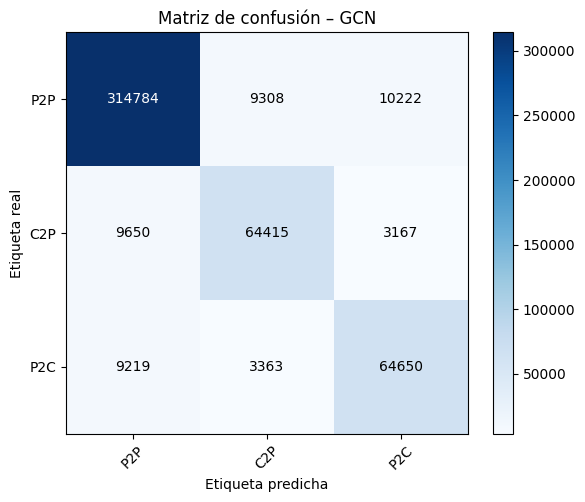

Matriz de confusión normalizada (%)


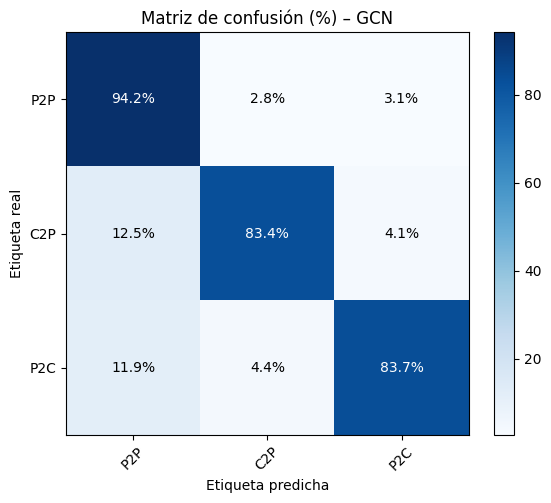

              precision    recall  f1-score   support

           0     0.9434    0.9416    0.9425    334314
           1     0.8356    0.8340    0.8348     77232
           2     0.8284    0.8371    0.8327     77232

    accuracy                         0.9081    488778
   macro avg     0.8692    0.8709    0.8700    488778
weighted avg     0.9082    0.9081    0.9082    488778



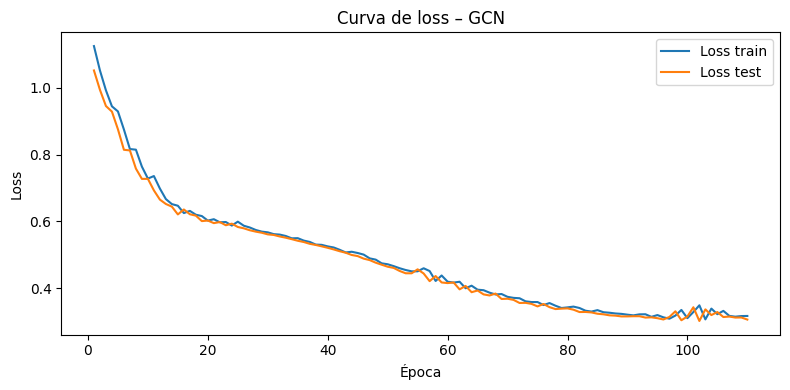

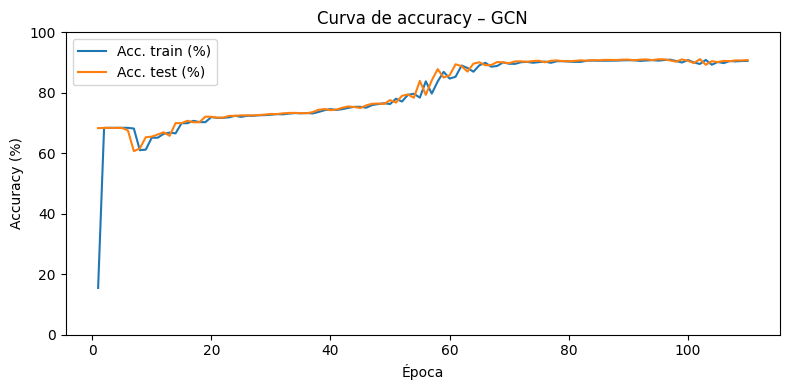


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 2.5922 acc_tr 21.11% | loss_te 1.3826 acc_te 60.38%
ep10  loss_tr 0.7574 acc_tr 74.02% | loss_te 0.6804 acc_te 76.10%
ep20  loss_tr 0.6188 acc_tr 77.79% | loss_te 0.5799 acc_te 78.94%
ep30  loss_tr 0.5291 acc_tr 80.44% | loss_te 0.4904 acc_te 80.96%
ep40  loss_tr 0.4576 acc_tr 83.21% | loss_te 0.4274 acc_te 84.24%
ep50  loss_tr 0.4148 acc_tr 85.37% | loss_te 0.3814 acc_te 86.80%
ep60  loss_tr 0.3927 acc_tr 86.05% | loss_te 0.3504 acc_te 87.83%
ep70  loss_tr 0.3676 acc_tr 87.00% | loss_te 0.3333 acc_te 88.19%
ep80  loss_tr 0.3589 acc_tr 87.52% | loss_te 0.3171 acc_te 88.91%
ep90  loss_tr 0.3443 acc_tr 88.02% | loss_te 0.3076 acc_te 89.11%
ep100  loss_tr 0.3355 acc_tr 88.58% | loss_te 0.2995 acc_te 89.29%
ep110  loss_tr 0.3279 acc_tr 88.79% | loss_te 0.2912 acc_te 89.77%
ep120  loss_tr 0.3193 acc_tr 89.23% | loss_te 0.2866 acc_te 89.76%
ep130  loss_tr 0.3148 acc_tr 88.97% | loss_te 0.2809 acc_te 90.05%
ep140  loss_tr 0.3075 acc_tr 89.4

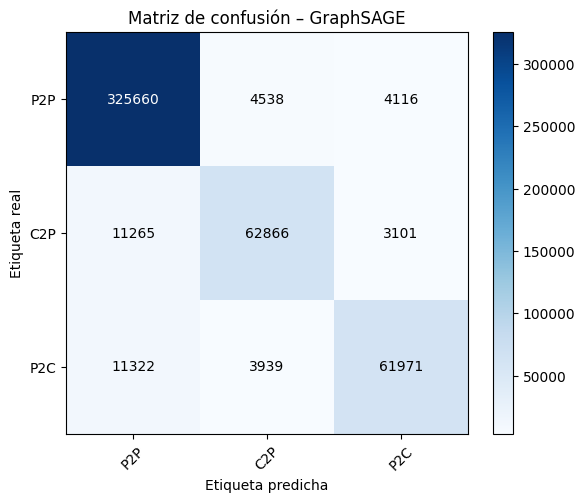

Matriz de confusión normalizada (%)


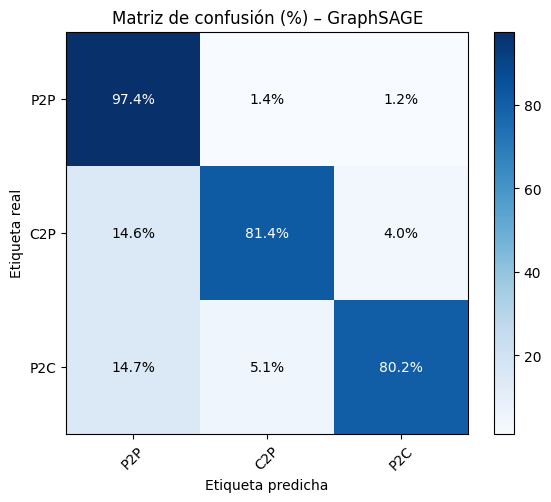

              precision    recall  f1-score   support

           0     0.9351    0.9741    0.9542    334314
           1     0.8812    0.8140    0.8463     77232
           2     0.8957    0.8024    0.8465     77232

    accuracy                         0.9217    488778
   macro avg     0.9040    0.8635    0.8823    488778
weighted avg     0.9204    0.9217    0.9201    488778



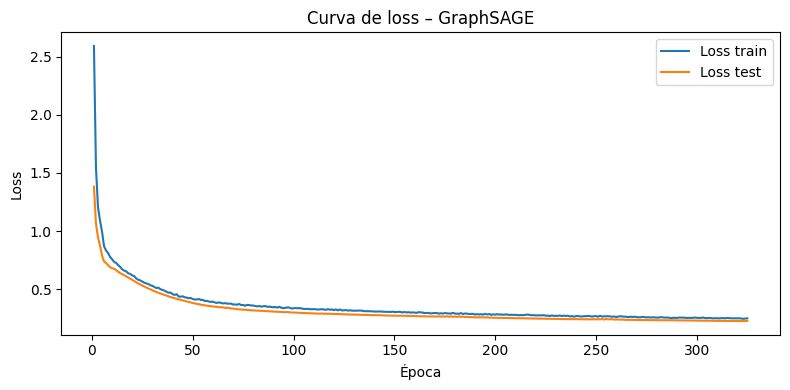

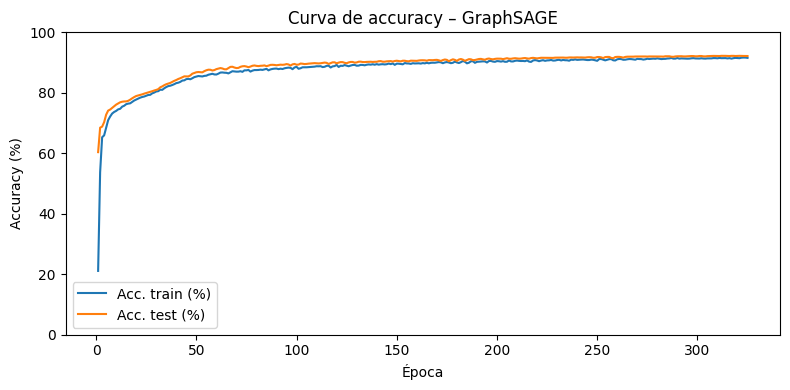


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.1429 acc_tr 14.56% | loss_te 1.0907 acc_te 69.73%
ep10  loss_tr 0.7103 acc_tr 71.97% | loss_te 0.6771 acc_te 71.72%
ep20  loss_tr 0.5803 acc_tr 76.30% | loss_te 0.5694 acc_te 76.74%
ep30  loss_tr 0.4842 acc_tr 82.02% | loss_te 0.4548 acc_te 82.63%
ep40  loss_tr 0.4206 acc_tr 84.40% | loss_te 0.4002 acc_te 85.00%
ep50  loss_tr 0.3896 acc_tr 85.70% | loss_te 0.3752 acc_te 85.91%
ep60  loss_tr 0.3670 acc_tr 86.71% | loss_te 0.3534 acc_te 87.15%
ep70  loss_tr 0.3459 acc_tr 87.74% | loss_te 0.3370 acc_te 87.88%
ep80  loss_tr 0.3353 acc_tr 88.01% | loss_te 0.3279 acc_te 88.47%
ep90  loss_tr 0.3201 acc_tr 88.78% | loss_te 0.3278 acc_te 88.81%
ep100  loss_tr 0.3120 acc_tr 88.86% | loss_te 0.3304 acc_te 88.46%
ep110  loss_tr 0.2965 acc_tr 89.76% | loss_te 0.3106 acc_te 89.54%
ep120  loss_tr 0.2902 acc_tr 89.65% | loss_te 0.3391 acc_te 89.19%
🛑  Early stop en epoch 123
Matriz de confusión sin normalizar


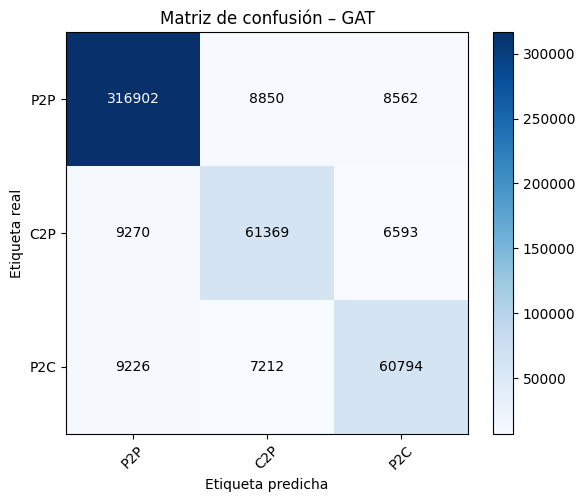

Matriz de confusión normalizada (%)


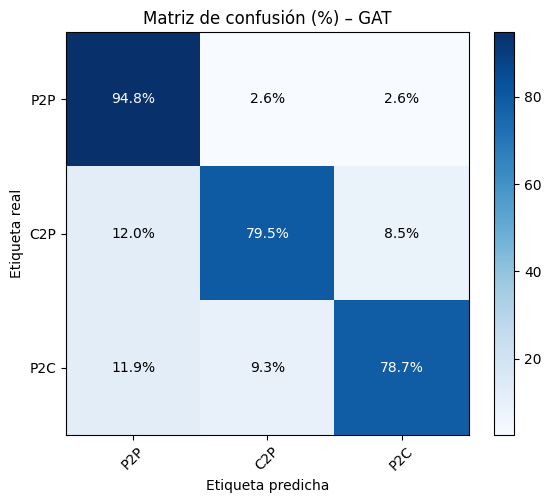

              precision    recall  f1-score   support

           0     0.9449    0.9479    0.9464    334314
           1     0.7926    0.7946    0.7936     77232
           2     0.8005    0.7872    0.7938     77232

    accuracy                         0.8983    488778
   macro avg     0.8460    0.8432    0.8446    488778
weighted avg     0.8980    0.8983    0.8981    488778



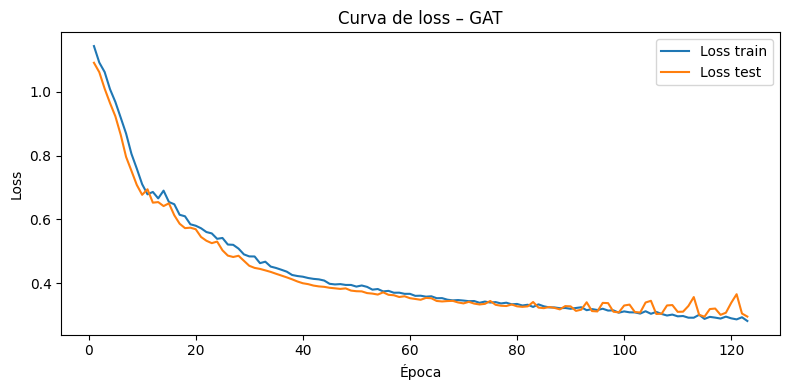

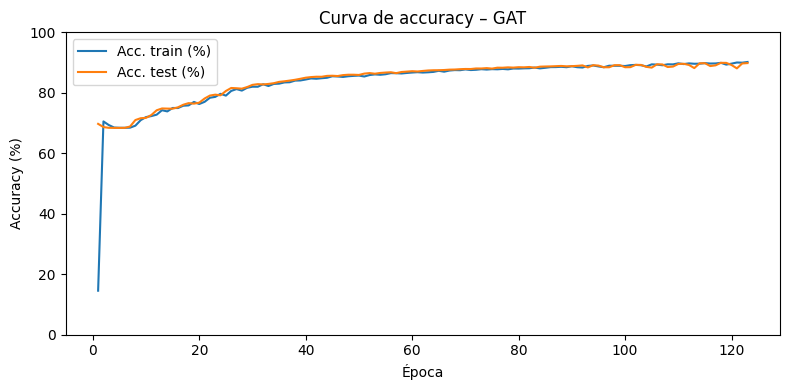

In [11]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 500
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()

        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


     
    


Viendo estos resultados igual me hace pensar que hay algun information leak , por el garfico de loss y accuracy que tenemos  ya que el test y y validacion son muy iguales y no suce de un sobreajuste donde se van deferiendo los puntajes despues de cierto punto.

Ademas si corremos esto en 50 epoch en muhco mas malo que en 100 epochs .... OBSERVAR

In [10]:
best_loss = float('inf')
best_ep   = 0
best_w    = None           # se llenará con los pesos óptimos

for epoch in range(1, epochs + 1):
    # ----- train -----
    model.train()
    h      = model.encode(g, feat)
    logits = model.decodeBilinear(g, h)
    loss   = F.cross_entropy(logits[train_m], labels[train_m])

    opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        preds_tr = logits[train_m].argmax(1)
        acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

    # ----- test -----
    model.eval()
    with torch.no_grad():
        logits_te = model.decodeBilinear(g, model.encode(g, feat))
        loss_te   = F.cross_entropy(logits_te[test_m], labels[test_m])
        preds_te  = logits_te[test_m].argmax(1)
        acc_te    = (preds_te == labels[test_m]).float().mean().item()

    # ----- almacenar histórico -----
    history["loss_tr"].append(loss.item())
    history["loss_te"].append(loss_te.item())
    history["acc_tr"].append(acc_tr * 100)
    history["acc_te"].append(acc_te * 100)

    # ----- guardar el mejor modelo -----
    if loss_te < best_loss - 1e-4:
        best_loss = loss_te
        best_ep   = epoch
        best_w    = model.state_dict()  # copia profunda de los pesos

    if epoch % 10 == 0 or epoch == 1:
        print(f"ep{epoch:03d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
              f"loss_te {loss_te:.4f} acc_te {acc_te:.2%}")

print(f"\nMejor epoch: {best_ep}  –  loss_te = {best_loss:.4f}")
model.load_state_dict(best_w)  # ← se restauran los pesos óptimos


ep001  loss_tr 0.3051 acc_tr 89.42% | loss_te 0.3298 acc_te 89.21%
ep010  loss_tr 0.2967 acc_tr 89.78% | loss_te 0.3529 acc_te 88.68%
ep020  loss_tr 0.2870 acc_tr 90.01% | loss_te 0.4553 acc_te 85.63%
ep030  loss_tr 0.2887 acc_tr 89.92% | loss_te 0.3628 acc_te 88.41%
ep040  loss_tr 0.2805 acc_tr 90.10% | loss_te 0.3983 acc_te 87.31%
ep050  loss_tr 0.2730 acc_tr 90.44% | loss_te 0.4411 acc_te 85.92%
ep060  loss_tr 0.2686 acc_tr 90.36% | loss_te 0.4943 acc_te 83.69%
ep070  loss_tr 0.2595 acc_tr 90.89% | loss_te 0.5248 acc_te 82.00%
ep080  loss_tr 0.2608 acc_tr 90.97% | loss_te 0.5276 acc_te 82.13%
ep090  loss_tr 0.2560 acc_tr 91.01% | loss_te 0.4629 acc_te 84.76%
ep100  loss_tr 0.2553 acc_tr 90.96% | loss_te 0.5501 acc_te 80.37%
ep110  loss_tr 0.2521 acc_tr 91.09% | loss_te 0.6357 acc_te 76.45%
ep120  loss_tr 0.2493 acc_tr 91.37% | loss_te 0.5482 acc_te 80.57%
ep130  loss_tr 0.2479 acc_tr 91.16% | loss_te 0.5098 acc_te 82.64%
ep140  loss_tr 0.2510 acc_tr 91.17% | loss_te 0.5718 acc_te 80

<All keys matched successfully>

#### Encoder : MLP


=== Training GCN ===
ep01 | loss_tr 1.0363 acc_tr 68.42% | loss_te 0.9836 acc_te 68.40%
ep10 | loss_tr 0.7271 acc_tr 67.64% | loss_te 0.7121 acc_te 67.28%
ep20 | loss_tr 0.6611 acc_tr 68.84% | loss_te 0.6552 acc_te 69.78%
ep30 | loss_tr 0.6374 acc_tr 70.10% | loss_te 0.6396 acc_te 70.03%
ep40 | loss_tr 0.6247 acc_tr 70.53% | loss_te 0.6228 acc_te 70.59%
ep50 | loss_tr 0.5960 acc_tr 72.15% | loss_te 0.5910 acc_te 72.39%
ep60 | loss_tr 0.5458 acc_tr 75.07% | loss_te 0.5402 acc_te 75.73%
ep70 | loss_tr 0.4901 acc_tr 78.88% | loss_te 0.4813 acc_te 78.92%
ep80 | loss_tr 0.4296 acc_tr 84.59% | loss_te 0.4301 acc_te 85.94%
ep90 | loss_tr 0.4005 acc_tr 87.27% | loss_te 0.4085 acc_te 86.30%
ep100 | loss_tr 0.3708 acc_tr 87.97% | loss_te 0.3568 acc_te 88.42%
ep110 | loss_tr 0.3497 acc_tr 88.89% | loss_te 0.3350 acc_te 88.98%
ep120 | loss_tr 0.3439 acc_tr 88.27% | loss_te 0.3166 acc_te 89.56%
ep130 | loss_tr 0.3140 acc_tr 89.50% | loss_te 0.3035 acc_te 89.86%
ep140 | loss_tr 0.2983 acc_tr 89.56%

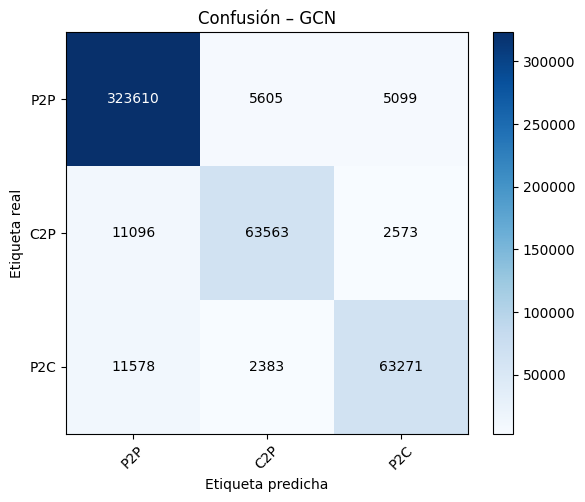

Matriz de confusión normalizada (%)


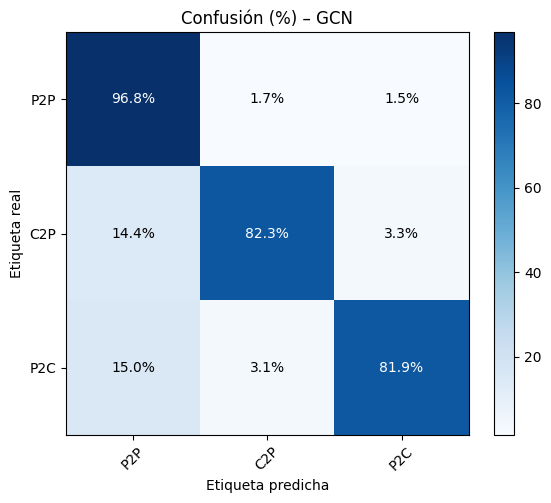

              precision    recall  f1-score   support

           0     0.9345    0.9680    0.9510    334314
           1     0.8884    0.8230    0.8544     77232
           2     0.8919    0.8192    0.8540     77232

    accuracy                         0.9216    488778
   macro avg     0.9049    0.8701    0.8865    488778
weighted avg     0.9205    0.9216    0.9204    488778



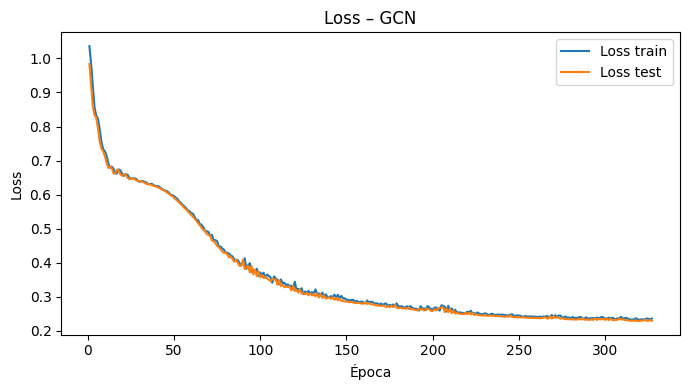

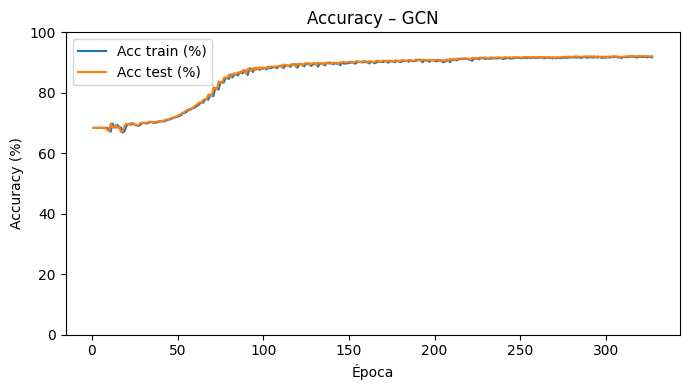


=== Training GraphSAGE ===
ep01 | loss_tr 1.0131 acc_tr 68.42% | loss_te 0.9767 acc_te 68.40%
ep10 | loss_tr 0.7968 acc_tr 68.42% | loss_te 0.7858 acc_te 68.40%
ep20 | loss_tr 0.6705 acc_tr 76.63% | loss_te 0.6435 acc_te 77.45%
ep30 | loss_tr 0.5832 acc_tr 78.50% | loss_te 0.5599 acc_te 79.20%
ep40 | loss_tr 0.5028 acc_tr 81.37% | loss_te 0.4823 acc_te 81.89%
ep50 | loss_tr 0.4448 acc_tr 83.64% | loss_te 0.4161 acc_te 84.71%
ep60 | loss_tr 0.3986 acc_tr 85.68% | loss_te 0.3673 acc_te 86.73%
ep70 | loss_tr 0.3641 acc_tr 87.00% | loss_te 0.3357 acc_te 87.97%
ep80 | loss_tr 0.3378 acc_tr 87.78% | loss_te 0.3124 acc_te 88.73%
ep90 | loss_tr 0.3168 acc_tr 88.57% | loss_te 0.2919 acc_te 89.42%
ep100 | loss_tr 0.3002 acc_tr 89.22% | loss_te 0.2762 acc_te 90.24%
ep110 | loss_tr 0.2840 acc_tr 90.05% | loss_te 0.2604 acc_te 90.82%
ep120 | loss_tr 0.2716 acc_tr 90.62% | loss_te 0.2540 acc_te 91.05%
ep130 | loss_tr 0.2612 acc_tr 90.99% | loss_te 0.2415 acc_te 91.62%
ep140 | loss_tr 0.2556 acc_tr 

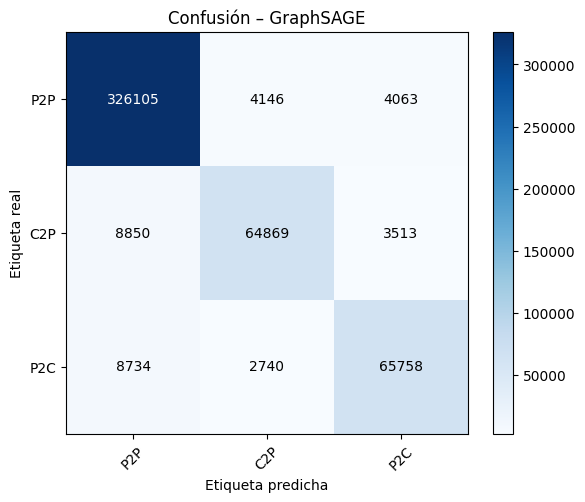

Matriz de confusión normalizada (%)


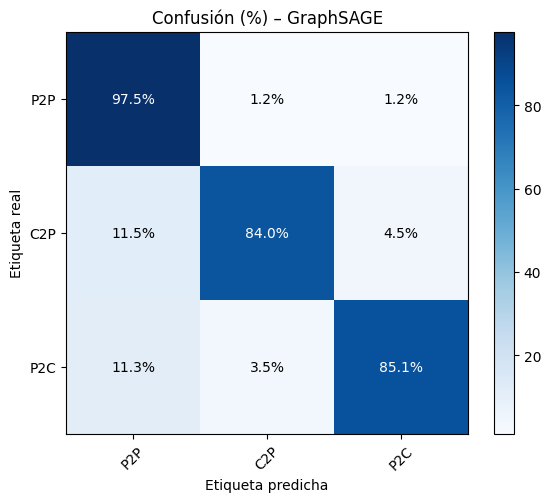

              precision    recall  f1-score   support

           0     0.9488    0.9754    0.9620    334314
           1     0.9040    0.8399    0.8708     77232
           2     0.8967    0.8514    0.8735     77232

    accuracy                         0.9344    488778
   macro avg     0.9165    0.8889    0.9021    488778
weighted avg     0.9335    0.9344    0.9336    488778



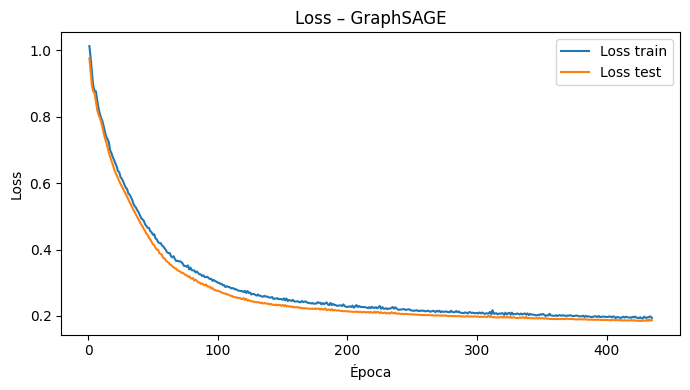

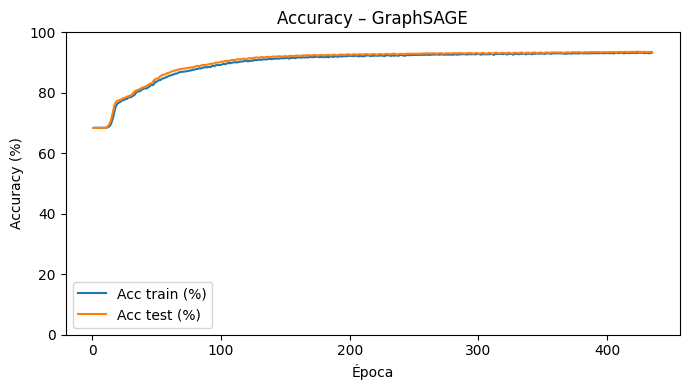


=== Training GAT ===
ep01 | loss_tr 1.0690 acc_tr 68.59% | loss_te 1.0243 acc_te 68.40%
ep10 | loss_tr 0.7512 acc_tr 69.28% | loss_te 0.7488 acc_te 68.44%
ep20 | loss_tr 0.6521 acc_tr 68.08% | loss_te 0.6589 acc_te 68.90%
ep30 | loss_tr 0.5966 acc_tr 73.74% | loss_te 0.6193 acc_te 73.66%
ep40 | loss_tr 0.5723 acc_tr 74.32% | loss_te 0.5266 acc_te 78.53%
ep50 | loss_tr 0.5031 acc_tr 80.66% | loss_te 0.4967 acc_te 80.89%
ep60 | loss_tr 0.4527 acc_tr 84.69% | loss_te 0.4756 acc_te 84.70%
ep70 | loss_tr 0.5136 acc_tr 79.47% | loss_te 0.4906 acc_te 79.55%
ep80 | loss_tr 0.3852 acc_tr 88.28% | loss_te 0.4147 acc_te 88.43%
ep90 | loss_tr 0.3654 acc_tr 87.55% | loss_te 0.3820 acc_te 87.72%
🛑  Early stop en época 95
Matriz de confusión sin normalizar


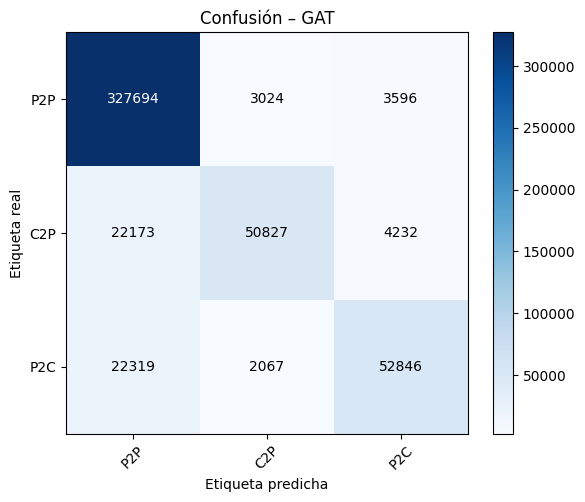

Matriz de confusión normalizada (%)


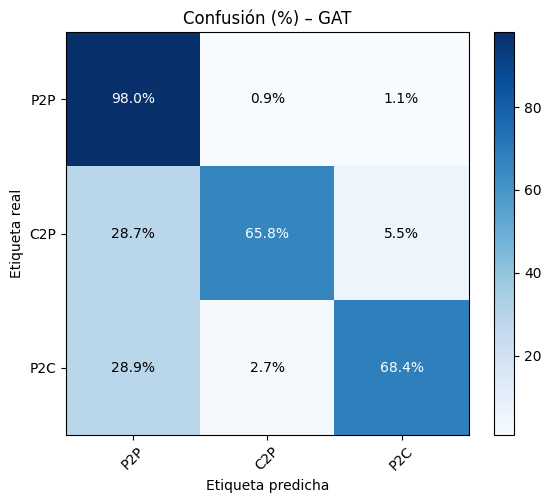

              precision    recall  f1-score   support

           0     0.8805    0.9802    0.9277    334314
           1     0.9090    0.6581    0.7635     77232
           2     0.8710    0.6843    0.7664     77232

    accuracy                         0.8825    488778
   macro avg     0.8868    0.7742    0.8192    488778
weighted avg     0.8835    0.8825    0.8762    488778



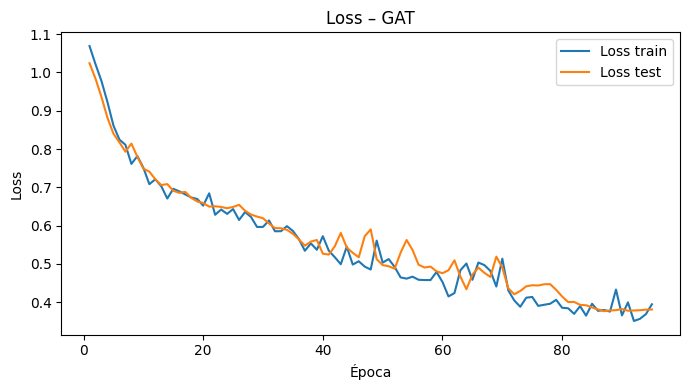

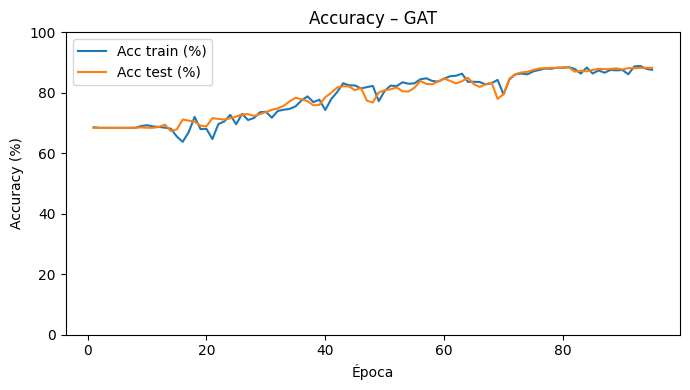

In [12]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 500
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        
        opt.zero_grad()
        loss.backward() 
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()



In [9]:

for split, m in zip(["train", "test"], [train_m, test_m]):
    num = int(m.sum())
    clases = torch.bincount(labels[m], minlength=3).tolist()
    print(f"{split:<5}: {num:>7}  →  P2P={clases[0]}  C2P={clases[1]}  P2C={clases[2]}")


train:  488776  →  P2P=334418  C2P=77179  P2C=77179
test :  488778  →  P2P=334314  C2P=77232  P2C=77232


In [ ]:
import numpy as np
from copy import deepcopy
from sklearn.metrics import f1_score

def permutation_importance(model, g, features, labels, test_mask, metric=f1_score):
    model.eval()
    base_logits = model.decodeBilinear(g, model.encode(g, features))
    base_preds = base_logits[test_mask].argmax(dim=1).cpu()
    base_score = metric(labels[test_mask].cpu(), base_preds, average='macro')

    importances = []
    for i in range(features.shape[1]):
        features_shuffled = features.clone()
        perm = torch.randperm(features.shape[0])
        features_shuffled[:, i] = features_shuffled[perm, i]

        logits = model.decodeBilinear(g, model.encode(g, features_shuffled))
        preds = logits[test_mask].argmax(dim=1).cpu()
        score = metric(labels[test_mask].cpu(), preds, average='macro')
        delta = base_score - score
        importances.append(delta)

    return importances
import matplotlib.pyplot as plt

importances = permutation_importance(model, g, feat, labels, test_m)

plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances)
plt.xlabel("Índice del atributo")
plt.ylabel("Importancia (∆F1-macro)")
plt.title("Importancia de atributos por permutación")
plt.tight_layout()
plt.show()


### CASO 1

* Con mis attr

En este caso el split si es leaky, es decir ambas aritas de un mismo par de nodos pueden estar separadas en el split quedar una en el test y otro en train.

In [5]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [6]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification_leaky(train_size=0.5, seed=42)

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 439316.59it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split_leaky] train=488,777  test=488,777
  clases train 0/1/2 → {0: 334546, 1: 77184, 2: 77047}
  clases test  0/1/2 → {0: 334186, 2: 77364, 1: 77227}


#### Encoder: Bilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1236 acc_tr 15.31% | loss_te 1.0494 acc_te 68.32%
ep10  loss_tr 0.7794 acc_tr 67.30% | loss_te 0.7247 acc_te 68.97%
ep20  loss_tr 0.6043 acc_tr 70.60% | loss_te 0.5818 acc_te 71.72%
ep30  loss_tr 0.5363 acc_tr 73.99% | loss_te 0.5263 acc_te 74.09%
ep40  loss_tr 0.4661 acc_tr 78.16% | loss_te 0.4566 acc_te 77.77%
ep50  loss_tr 0.4029 acc_tr 85.62% | loss_te 0.4270 acc_te 88.23%
ep60  loss_tr 0.3881 acc_tr 87.73% | loss_te 0.3634 acc_te 89.74%
ep70  loss_tr 0.3458 acc_tr 90.42% | loss_te 0.3404 acc_te 90.67%
ep80  loss_tr 0.3360 acc_tr 90.27% | loss_te 0.3249 acc_te 90.72%
ep90  loss_tr 0.3205 acc_tr 90.52% | loss_te 0.3100 acc_te 91.16%
ep100  loss_tr 0.3123 acc_tr 90.70% | loss_te 0.3037 acc_te 91.20%
ep110  loss_tr 0.2984 acc_tr 91.07% | loss_te 0.3034 acc_te 90.75%
🛑  Early stop en epoch 120
Matriz de confusión sin normalizar


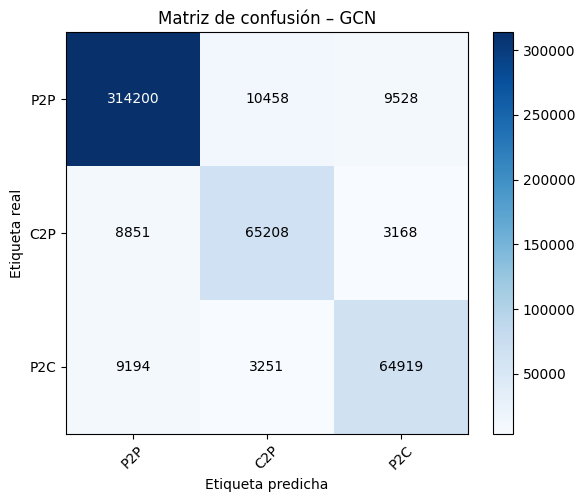

Matriz de confusión normalizada (%)


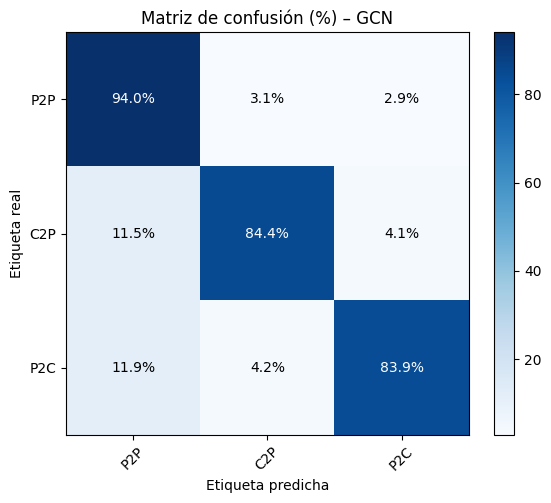

              precision    recall  f1-score   support

           0     0.9457    0.9402    0.9429    334186
           1     0.8263    0.8444    0.8352     77227
           2     0.8364    0.8391    0.8378     77364

    accuracy                         0.9091    488777
   macro avg     0.8695    0.8746    0.8720    488777
weighted avg     0.9095    0.9091    0.9093    488777



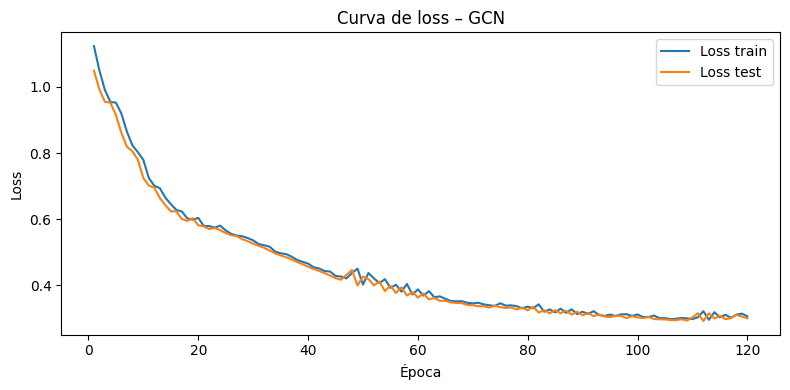

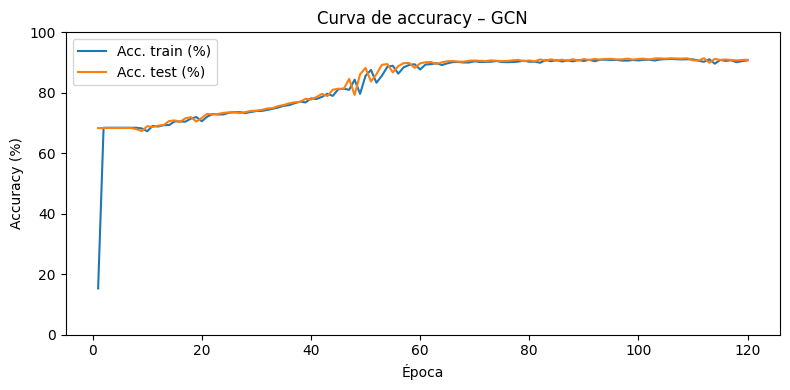


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 1.8494 acc_tr 17.45% | loss_te 1.2818 acc_te 21.49%
ep10  loss_tr 0.7882 acc_tr 72.74% | loss_te 0.7133 acc_te 73.81%
ep20  loss_tr 0.6432 acc_tr 77.41% | loss_te 0.6113 acc_te 78.27%
ep30  loss_tr 0.5773 acc_tr 79.04% | loss_te 0.5493 acc_te 79.89%
ep40  loss_tr 0.5329 acc_tr 80.26% | loss_te 0.4993 acc_te 81.15%
ep50  loss_tr 0.4769 acc_tr 82.87% | loss_te 0.4367 acc_te 83.65%
ep60  loss_tr 0.4156 acc_tr 85.48% | loss_te 0.3762 acc_te 86.96%
ep70  loss_tr 0.3808 acc_tr 87.00% | loss_te 0.3371 acc_te 88.70%
ep80  loss_tr 0.3548 acc_tr 87.41% | loss_te 0.3147 acc_te 89.02%
ep90  loss_tr 0.3427 acc_tr 88.00% | loss_te 0.3055 acc_te 89.35%
ep100  loss_tr 0.3322 acc_tr 88.76% | loss_te 0.2937 acc_te 89.82%
ep110  loss_tr 0.3231 acc_tr 88.87% | loss_te 0.2895 acc_te 89.79%
ep120  loss_tr 0.3162 acc_tr 89.23% | loss_te 0.2836 acc_te 90.13%
ep130  loss_tr 0.3094 acc_tr 89.28% | loss_te 0.2792 acc_te 90.23%
ep140  loss_tr 0.3036 acc_tr 89.6

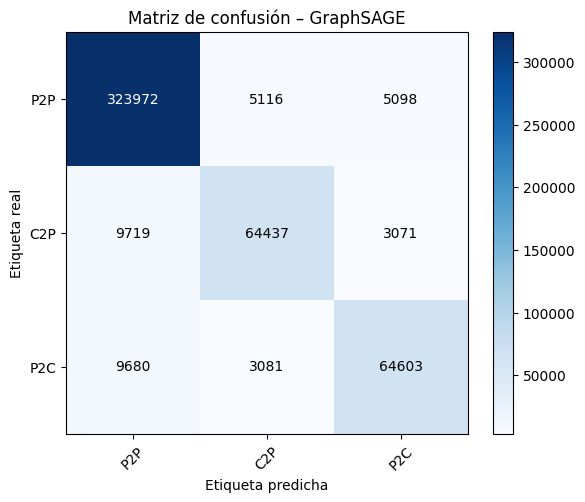

Matriz de confusión normalizada (%)


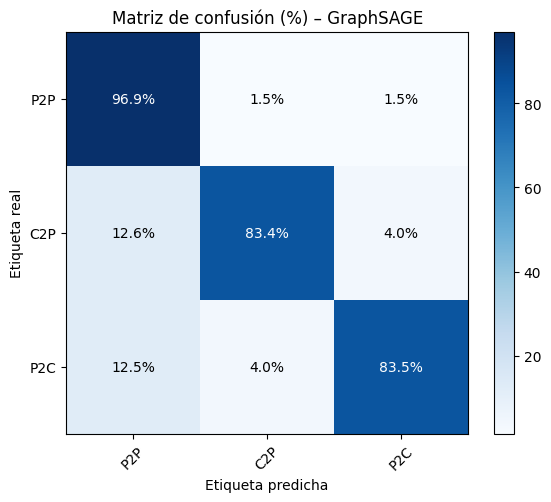

              precision    recall  f1-score   support

           0     0.9435    0.9694    0.9563    334186
           1     0.8871    0.8344    0.8600     77227
           2     0.8877    0.8351    0.8606     77364

    accuracy                         0.9268    488777
   macro avg     0.9061    0.8796    0.8923    488777
weighted avg     0.9258    0.9268    0.9259    488777



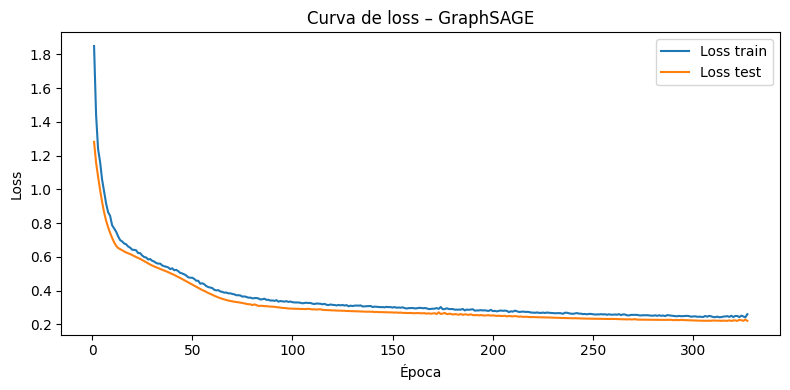

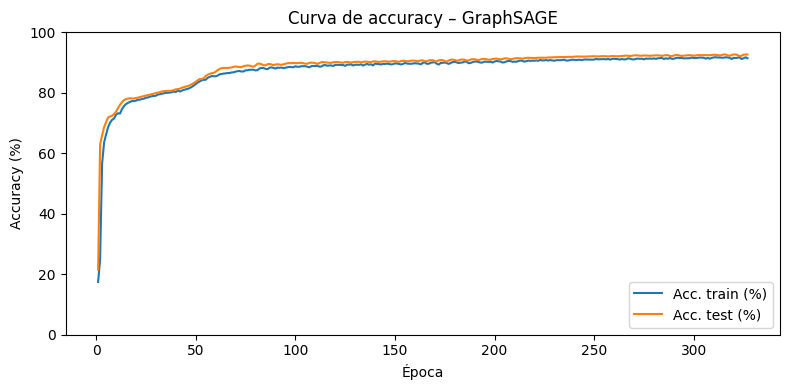


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.0974 acc_tr 63.28% | loss_te 1.0467 acc_te 68.90%
ep10  loss_tr 0.6705 acc_tr 75.24% | loss_te 0.6559 acc_te 75.60%
ep20  loss_tr 0.5517 acc_tr 78.35% | loss_te 0.5409 acc_te 78.61%
ep30  loss_tr 0.4976 acc_tr 80.44% | loss_te 0.4859 acc_te 80.62%
ep40  loss_tr 0.4639 acc_tr 81.58% | loss_te 0.4508 acc_te 82.05%
ep50  loss_tr 0.4285 acc_tr 83.45% | loss_te 0.4195 acc_te 83.32%
ep60  loss_tr 0.4071 acc_tr 84.61% | loss_te 0.3954 acc_te 85.22%
ep70  loss_tr 0.3865 acc_tr 85.76% | loss_te 0.3793 acc_te 86.24%
ep80  loss_tr 0.3730 acc_tr 86.49% | loss_te 0.3608 acc_te 86.87%
ep90  loss_tr 0.3530 acc_tr 87.44% | loss_te 0.3484 acc_te 87.38%
ep100  loss_tr 0.3366 acc_tr 88.12% | loss_te 0.3339 acc_te 88.58%
ep110  loss_tr 0.3199 acc_tr 88.64% | loss_te 0.3208 acc_te 88.71%
ep120  loss_tr 0.3076 acc_tr 89.38% | loss_te 0.3064 acc_te 89.47%
ep130  loss_tr 0.3047 acc_tr 89.19% | loss_te 0.3074 acc_te 90.20%
ep140  loss_tr 0.2834 acc_tr 90.21% | l

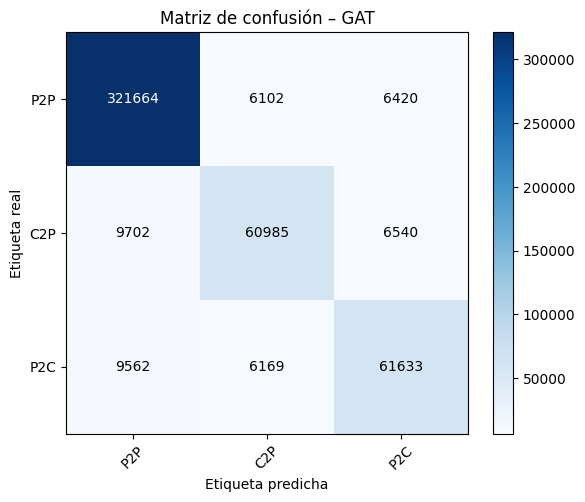

Matriz de confusión normalizada (%)


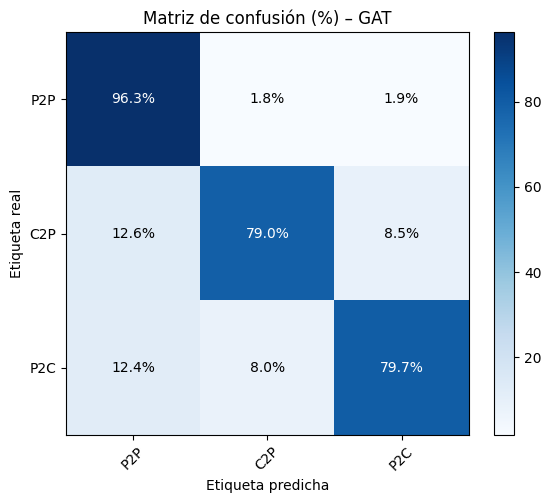

              precision    recall  f1-score   support

           0     0.9435    0.9625    0.9529    334186
           1     0.8325    0.7897    0.8105     77227
           2     0.8263    0.7967    0.8112     77364

    accuracy                         0.9090    488777
   macro avg     0.8674    0.8496    0.8582    488777
weighted avg     0.9074    0.9090    0.9080    488777



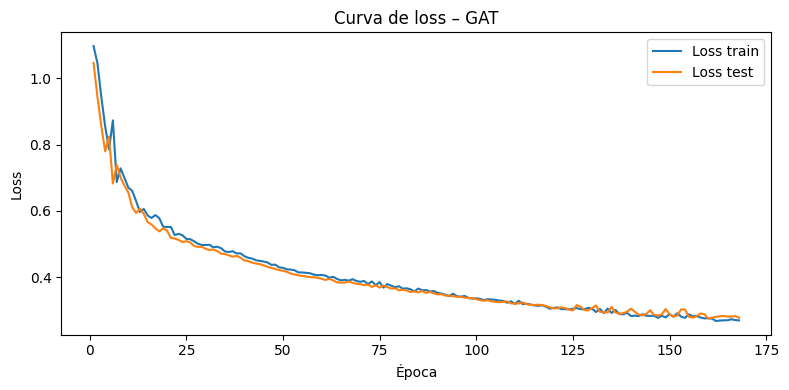

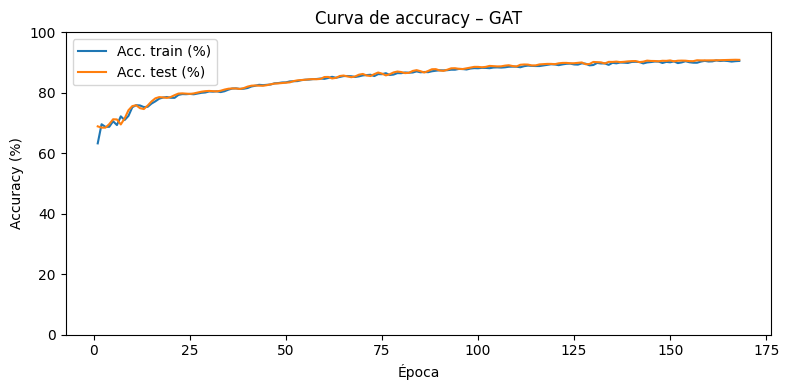

In [8]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 500
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")



#### Encoder: MLP


=== Training GCN ===
ep01 | loss_tr 1.1592 acc_tr 15.76% | loss_te 1.0968 acc_te 18.16%
ep10 | loss_tr 0.7186 acc_tr 68.45% | loss_te 0.6885 acc_te 69.44%
ep20 | loss_tr 0.6700 acc_tr 66.91% | loss_te 0.6535 acc_te 70.04%
ep30 | loss_tr 0.6400 acc_tr 69.34% | loss_te 0.6426 acc_te 68.61%
ep40 | loss_tr 0.6168 acc_tr 71.20% | loss_te 0.6155 acc_te 71.44%
ep50 | loss_tr 0.5810 acc_tr 73.22% | loss_te 0.5778 acc_te 73.14%
ep60 | loss_tr 0.5343 acc_tr 75.30% | loss_te 0.5299 acc_te 75.68%
ep70 | loss_tr 0.4626 acc_tr 78.94% | loss_te 0.4543 acc_te 79.42%
ep80 | loss_tr 0.4073 acc_tr 86.24% | loss_te 0.3929 acc_te 87.49%
ep90 | loss_tr 0.3634 acc_tr 88.67% | loss_te 0.3606 acc_te 88.72%
ep100 | loss_tr 0.3410 acc_tr 89.10% | loss_te 0.3419 acc_te 88.70%
ep110 | loss_tr 0.3263 acc_tr 89.02% | loss_te 0.3213 acc_te 88.86%
ep120 | loss_tr 0.3105 acc_tr 89.06% | loss_te 0.3054 acc_te 89.71%
ep130 | loss_tr 0.2956 acc_tr 89.76% | loss_te 0.2937 acc_te 89.60%
ep140 | loss_tr 0.2904 acc_tr 89.90%

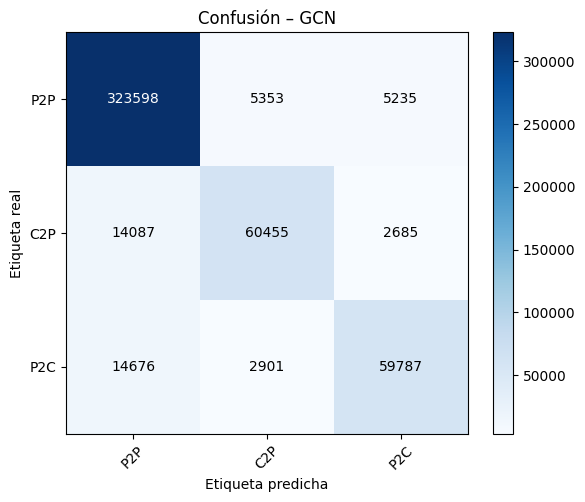

Matriz de confusión normalizada (%)


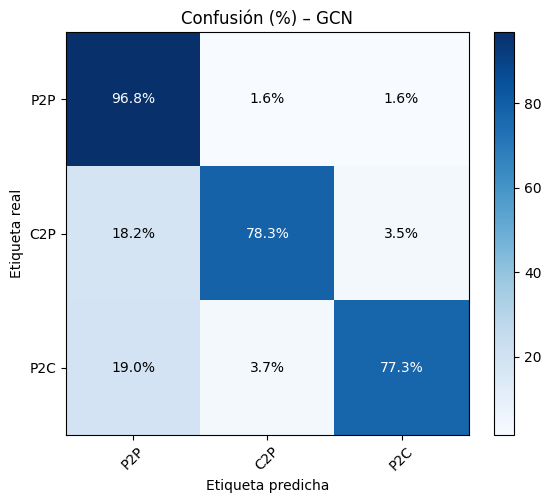

              precision    recall  f1-score   support

           0     0.9184    0.9683    0.9427    334186
           1     0.8799    0.7828    0.8285     77227
           2     0.8830    0.7728    0.8242     77364

    accuracy                         0.9081    488777
   macro avg     0.8938    0.8413    0.8651    488777
weighted avg     0.9067    0.9081    0.9059    488777



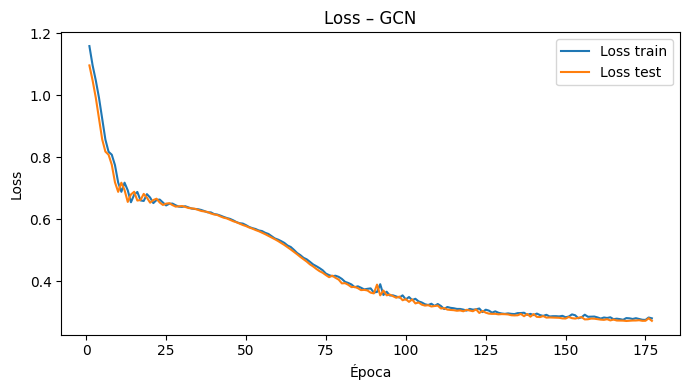

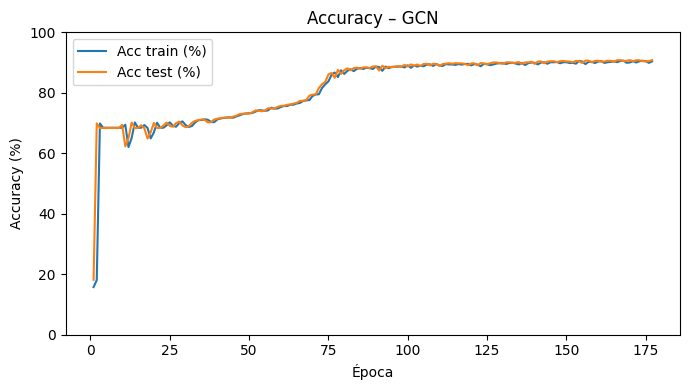


=== Training GraphSAGE ===
ep01 | loss_tr 1.0630 acc_tr 63.66% | loss_te 0.9982 acc_te 68.37%
ep10 | loss_tr 0.8217 acc_tr 69.06% | loss_te 0.7994 acc_te 69.79%
ep20 | loss_tr 0.6554 acc_tr 77.53% | loss_te 0.6320 acc_te 78.23%
ep30 | loss_tr 0.5525 acc_tr 79.48% | loss_te 0.5329 acc_te 79.89%
ep40 | loss_tr 0.4480 acc_tr 83.74% | loss_te 0.4203 acc_te 84.90%
ep50 | loss_tr 0.3769 acc_tr 86.82% | loss_te 0.3445 acc_te 87.87%
ep60 | loss_tr 0.3367 acc_tr 88.21% | loss_te 0.3141 acc_te 88.97%
ep70 | loss_tr 0.3149 acc_tr 88.95% | loss_te 0.2918 acc_te 89.66%
ep80 | loss_tr 0.2971 acc_tr 89.62% | loss_te 0.2699 acc_te 90.54%
ep90 | loss_tr 0.2733 acc_tr 90.44% | loss_te 0.2514 acc_te 91.26%
ep100 | loss_tr 0.2659 acc_tr 90.70% | loss_te 0.2379 acc_te 91.81%
ep110 | loss_tr 0.2553 acc_tr 91.25% | loss_te 0.2316 acc_te 92.09%
ep120 | loss_tr 0.2489 acc_tr 91.49% | loss_te 0.2252 acc_te 92.36%
ep130 | loss_tr 0.2388 acc_tr 91.70% | loss_te 0.2215 acc_te 92.51%
ep140 | loss_tr 0.2340 acc_tr 

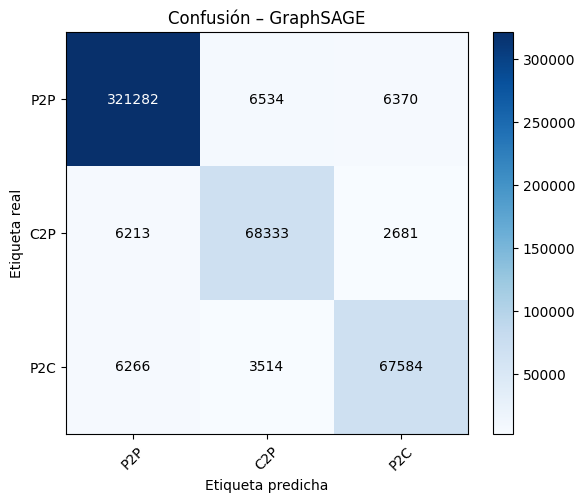

Matriz de confusión normalizada (%)


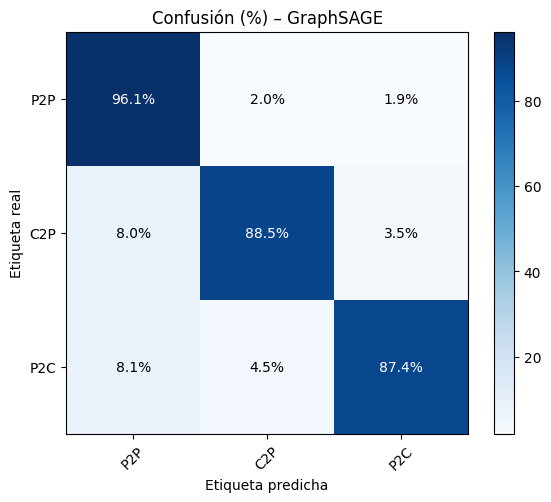

              precision    recall  f1-score   support

           0     0.9626    0.9614    0.9620    334186
           1     0.8718    0.8848    0.8783     77227
           2     0.8819    0.8736    0.8777     77364

    accuracy                         0.9354    488777
   macro avg     0.9054    0.9066    0.9060    488777
weighted avg     0.9355    0.9354    0.9354    488777



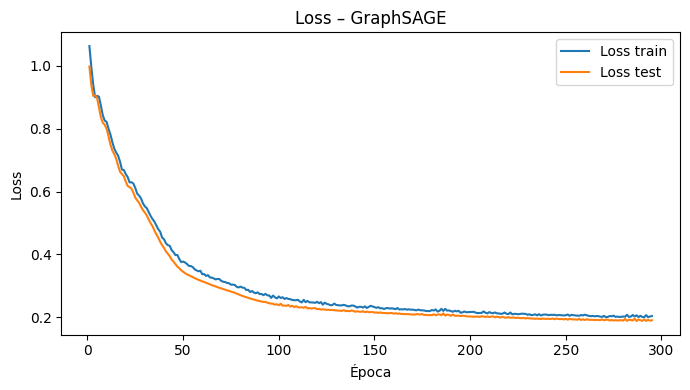

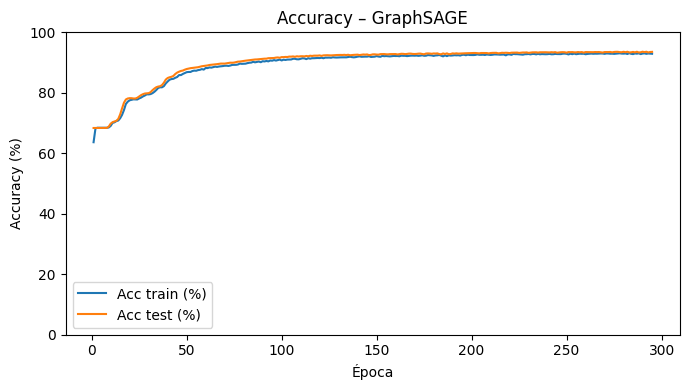


=== Training GAT ===
ep01 | loss_tr 1.1597 acc_tr 15.76% | loss_te 1.1321 acc_te 15.83%
ep10 | loss_tr 0.8492 acc_tr 68.45% | loss_te 0.8086 acc_te 68.37%
ep20 | loss_tr 0.6789 acc_tr 72.72% | loss_te 0.6374 acc_te 71.74%
ep30 | loss_tr 0.5350 acc_tr 78.53% | loss_te 0.5395 acc_te 77.38%
ep40 | loss_tr 0.4755 acc_tr 81.35% | loss_te 0.4920 acc_te 80.11%
ep50 | loss_tr 0.4226 acc_tr 84.14% | loss_te 0.4206 acc_te 84.26%
ep60 | loss_tr 0.3811 acc_tr 85.94% | loss_te 0.3870 acc_te 85.81%
ep70 | loss_tr 0.3625 acc_tr 86.73% | loss_te 0.3687 acc_te 86.63%
ep80 | loss_tr 0.3448 acc_tr 87.19% | loss_te 0.3403 acc_te 87.53%
ep90 | loss_tr 0.3276 acc_tr 87.97% | loss_te 0.3321 acc_te 87.85%
ep100 | loss_tr 0.3090 acc_tr 88.69% | loss_te 0.3128 acc_te 88.44%
ep110 | loss_tr 0.3039 acc_tr 88.78% | loss_te 0.2935 acc_te 89.31%
ep120 | loss_tr 0.2914 acc_tr 89.29% | loss_te 0.2883 acc_te 89.53%
ep130 | loss_tr 0.2816 acc_tr 89.87% | loss_te 0.2732 acc_te 90.27%
ep140 | loss_tr 0.2749 acc_tr 89.90%

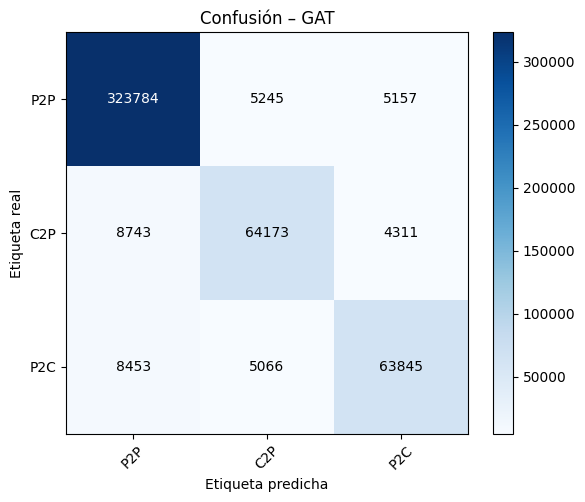

Matriz de confusión normalizada (%)


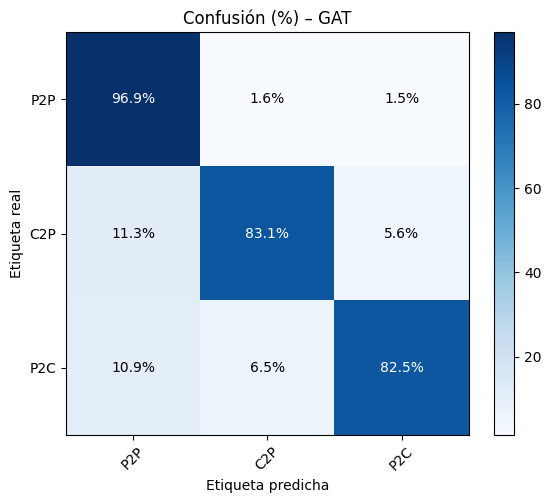

              precision    recall  f1-score   support

           0     0.9496    0.9689    0.9591    334186
           1     0.8616    0.8310    0.8460     77227
           2     0.8709    0.8253    0.8474     77364

    accuracy                         0.9244    488777
   macro avg     0.8940    0.8750    0.8842    488777
weighted avg     0.9232    0.9244    0.9236    488777



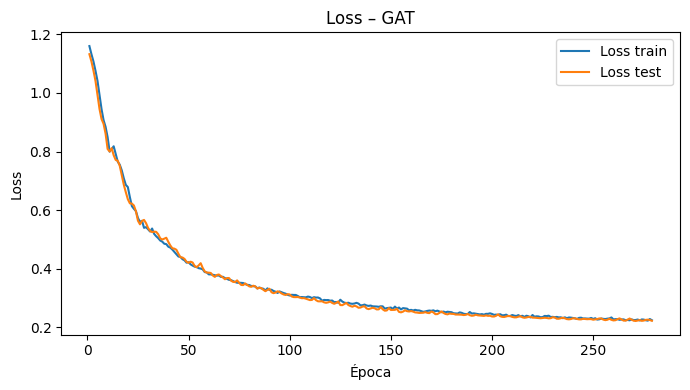

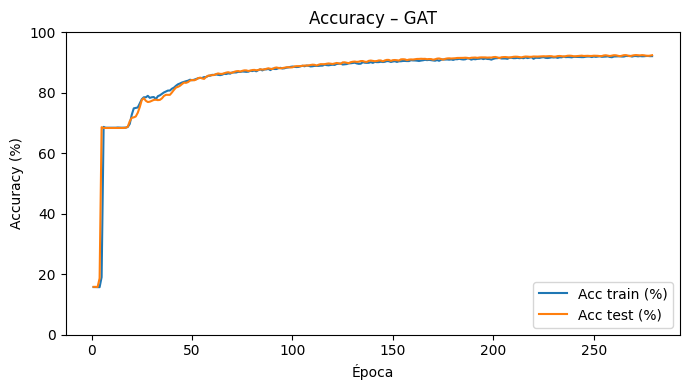

In [7]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 500
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        
        opt.zero_grad()
        loss.backward() 
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()



### Caso 2: Con attr = degre

In [6]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [7]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024Degree/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)



[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 479636.14it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=488776  test=488778
  clases train: {0: 334418, 2: 77179, 1: 77179}


#### Encode : Bilinear


=== Training GCN (Bilinear) ===
ep01  loss_tr 1.1137 acc_tr 15.69% | loss_te 1.0642 acc_te 68.42%
ep10  loss_tr 0.8004 acc_tr 68.42% | loss_te 0.7974 acc_te 67.64%
ep20  loss_tr 0.6616 acc_tr 69.67% | loss_te 0.6622 acc_te 68.98%
ep30  loss_tr 0.6468 acc_tr 70.38% | loss_te 0.6480 acc_te 69.84%
ep40  loss_tr 0.6303 acc_tr 69.39% | loss_te 0.6313 acc_te 68.85%
ep50  loss_tr 0.6157 acc_tr 71.31% | loss_te 0.6125 acc_te 70.72%
ep60  loss_tr 0.5934 acc_tr 71.87% | loss_te 0.5945 acc_te 70.89%
ep70  loss_tr 0.5708 acc_tr 72.43% | loss_te 0.5706 acc_te 72.00%
ep80  loss_tr 0.5517 acc_tr 73.26% | loss_te 0.5457 acc_te 74.97%
ep90  loss_tr 0.5144 acc_tr 77.75% | loss_te 0.5206 acc_te 79.87%
ep100  loss_tr 0.4957 acc_tr 82.21% | loss_te 0.5233 acc_te 76.49%
ep110  loss_tr 0.4850 acc_tr 81.93% | loss_te 0.5093 acc_te 85.03%
ep120  loss_tr 0.4692 acc_tr 85.92% | loss_te 0.4598 acc_te 84.35%
ep130  loss_tr 0.4501 acc_tr 84.84% | loss_te 0.4474 acc_te 84.72%
ep140  loss_tr 0.4442 acc_tr 87.00% | l

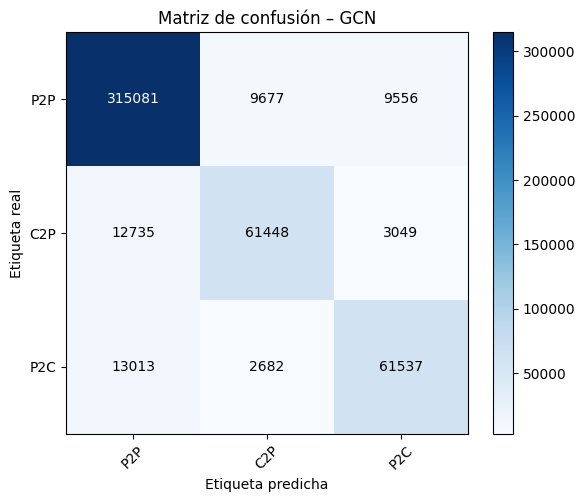

Matriz de confusión normalizada (%)


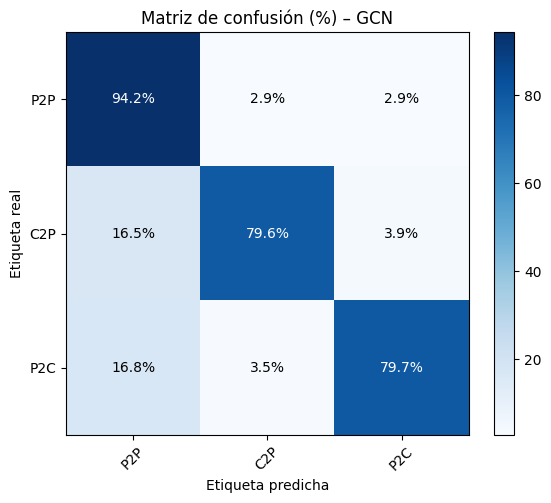

              precision    recall  f1-score   support

           0     0.9245    0.9425    0.9334    334314
           1     0.8325    0.7956    0.8137     77232
           2     0.8300    0.7968    0.8130     77232

    accuracy                         0.8962    488778
   macro avg     0.8623    0.8450    0.8534    488778
weighted avg     0.8950    0.8962    0.8954    488778



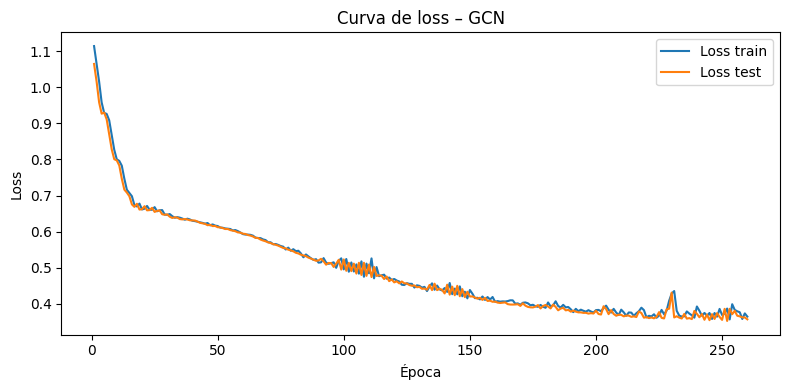

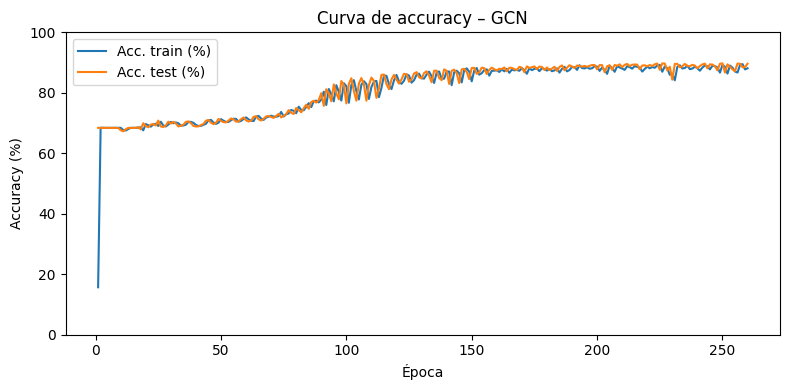


=== Training GraphSAGE (Bilinear) ===
ep01  loss_tr 5.5623 acc_tr 66.64% | loss_te 2.4763 acc_te 67.93%
ep10  loss_tr 1.2547 acc_tr 65.99% | loss_te 0.9070 acc_te 71.12%
ep20  loss_tr 0.8601 acc_tr 71.12% | loss_te 0.7389 acc_te 72.77%
ep30  loss_tr 0.7570 acc_tr 72.88% | loss_te 0.6822 acc_te 74.02%
ep40  loss_tr 0.6943 acc_tr 75.40% | loss_te 0.6284 acc_te 76.52%
ep50  loss_tr 0.6625 acc_tr 76.30% | loss_te 0.5980 acc_te 77.40%
ep60  loss_tr 0.6086 acc_tr 78.38% | loss_te 0.5659 acc_te 78.98%
ep70  loss_tr 0.5910 acc_tr 79.45% | loss_te 0.5418 acc_te 80.23%
ep80  loss_tr 0.5576 acc_tr 80.69% | loss_te 0.5249 acc_te 80.90%
ep90  loss_tr 0.5497 acc_tr 80.73% | loss_te 0.5090 acc_te 81.28%
ep100  loss_tr 0.5248 acc_tr 81.42% | loss_te 0.4955 acc_te 81.71%
ep110  loss_tr 0.5120 acc_tr 81.70% | loss_te 0.4809 acc_te 82.02%
ep120  loss_tr 0.4900 acc_tr 82.65% | loss_te 0.4674 acc_te 82.29%
ep130  loss_tr 0.4813 acc_tr 82.64% | loss_te 0.4558 acc_te 82.74%
ep140  loss_tr 0.4687 acc_tr 83.0

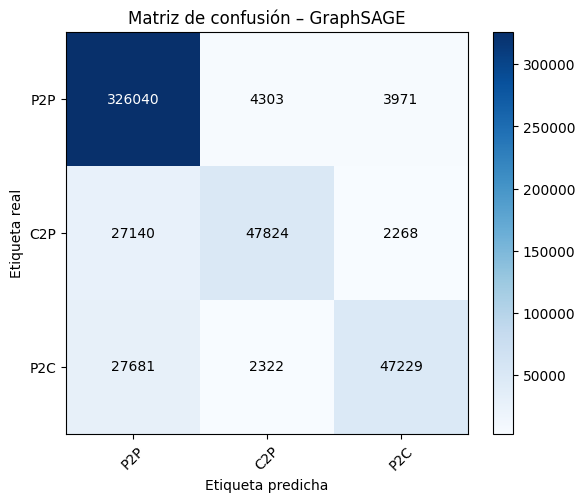

Matriz de confusión normalizada (%)


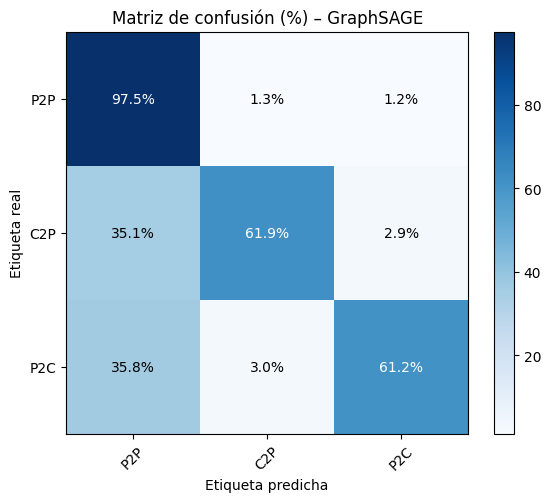

              precision    recall  f1-score   support

           0     0.8561    0.9753    0.9118    334314
           1     0.8783    0.6192    0.7264     77232
           2     0.8833    0.6115    0.7227     77232

    accuracy                         0.8615    488778
   macro avg     0.8726    0.7353    0.7869    488778
weighted avg     0.8639    0.8615    0.8526    488778



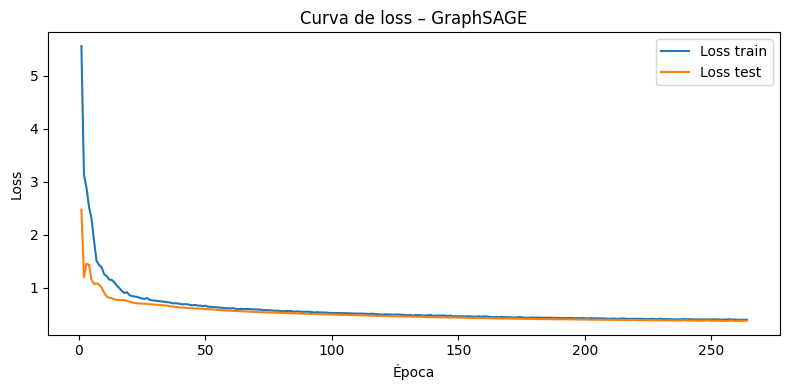

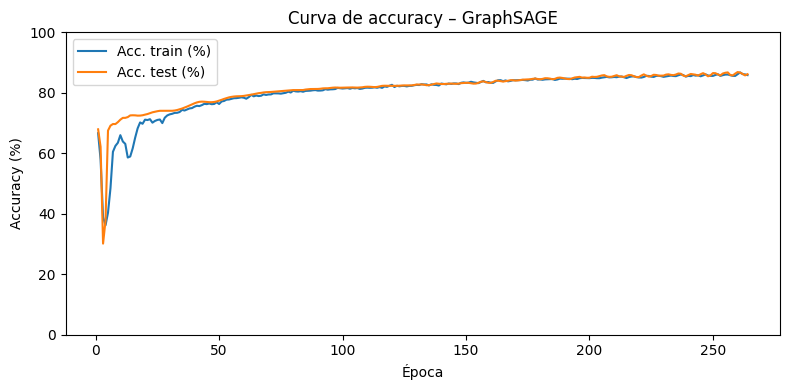


=== Training GAT (Bilinear) ===
ep01  loss_tr 1.0967 acc_tr 68.70% | loss_te 1.0711 acc_te 68.40%
ep10  loss_tr 0.8533 acc_tr 68.42% | loss_te 0.8282 acc_te 68.41%
ep20  loss_tr 0.7421 acc_tr 70.12% | loss_te 0.7269 acc_te 70.68%
ep30  loss_tr 0.7177 acc_tr 72.99% | loss_te 0.7075 acc_te 73.06%
ep40  loss_tr 0.6995 acc_tr 72.52% | loss_te 0.6926 acc_te 72.66%
ep50  loss_tr 0.6802 acc_tr 73.42% | loss_te 0.6658 acc_te 73.62%
ep60  loss_tr 0.6517 acc_tr 74.45% | loss_te 0.6349 acc_te 74.53%
ep70  loss_tr 0.6171 acc_tr 76.07% | loss_te 0.6006 acc_te 76.76%
ep80  loss_tr 0.5982 acc_tr 77.25% | loss_te 0.5686 acc_te 77.83%
ep90  loss_tr 0.5708 acc_tr 77.66% | loss_te 0.5452 acc_te 78.66%
ep100  loss_tr 0.5362 acc_tr 79.71% | loss_te 0.5432 acc_te 80.22%
ep110  loss_tr 0.5163 acc_tr 81.09% | loss_te 0.5048 acc_te 81.38%
ep120  loss_tr 0.5010 acc_tr 81.99% | loss_te 0.4865 acc_te 82.42%
ep130  loss_tr 0.4902 acc_tr 82.95% | loss_te 0.5040 acc_te 82.62%
ep140  loss_tr 0.4564 acc_tr 83.72% | l

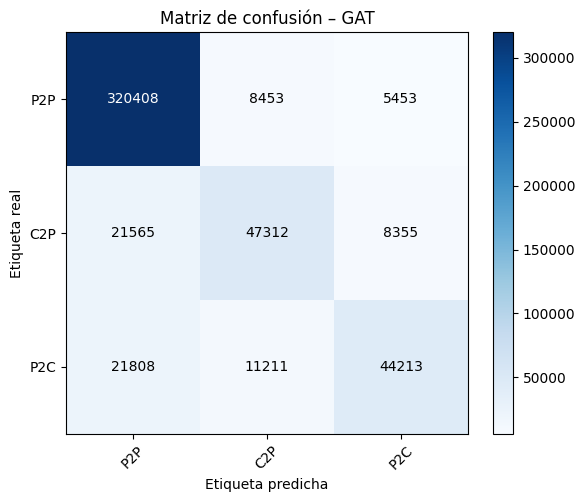

Matriz de confusión normalizada (%)


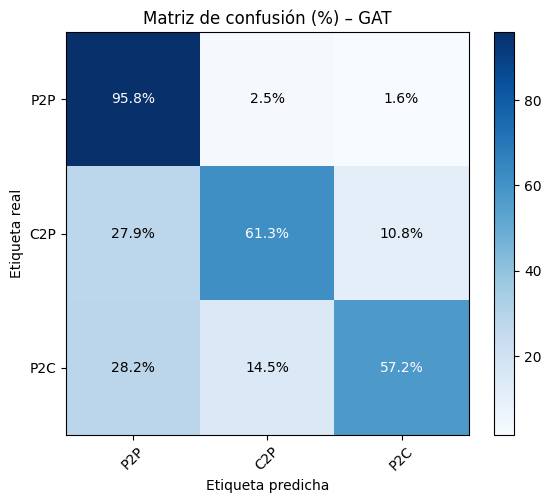

              precision    recall  f1-score   support

           0     0.8808    0.9584    0.9179    334314
           1     0.7064    0.6126    0.6562     77232
           2     0.7620    0.5725    0.6538     77232

    accuracy                         0.8428    488778
   macro avg     0.7831    0.7145    0.7426    488778
weighted avg     0.8345    0.8428    0.8348    488778



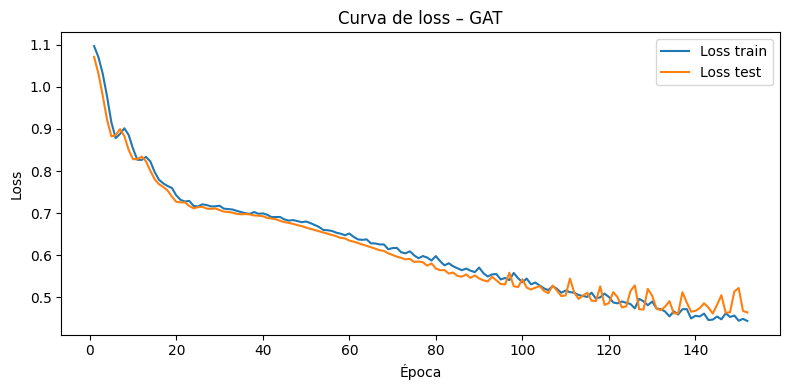

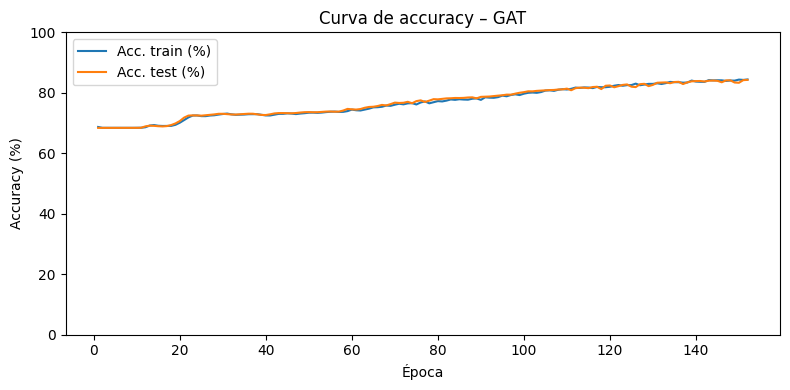

In [8]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 500
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()

    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


#### Encoder : MLP


=== Training GCN ===
ep01 | loss_tr 1.0341 acc_tr 68.42% | loss_te 1.0045 acc_te 68.40%
ep10 | loss_tr 0.8427 acc_tr 68.42% | loss_te 0.8274 acc_te 68.40%
ep20 | loss_tr 0.7245 acc_tr 68.42% | loss_te 0.7121 acc_te 68.40%
ep30 | loss_tr 0.6784 acc_tr 70.43% | loss_te 0.6743 acc_te 70.40%
ep40 | loss_tr 0.6444 acc_tr 69.33% | loss_te 0.6429 acc_te 69.92%
ep50 | loss_tr 0.6196 acc_tr 69.99% | loss_te 0.6176 acc_te 70.64%
ep60 | loss_tr 0.5786 acc_tr 71.61% | loss_te 0.5742 acc_te 72.16%
ep70 | loss_tr 0.5333 acc_tr 77.76% | loss_te 0.5317 acc_te 78.34%
ep80 | loss_tr 0.5069 acc_tr 79.62% | loss_te 0.5046 acc_te 79.30%
ep90 | loss_tr 0.4862 acc_tr 79.91% | loss_te 0.4903 acc_te 80.28%
ep100 | loss_tr 0.4762 acc_tr 80.70% | loss_te 0.4740 acc_te 80.69%
ep110 | loss_tr 0.4668 acc_tr 81.10% | loss_te 0.4609 acc_te 81.14%
ep120 | loss_tr 0.4422 acc_tr 82.01% | loss_te 0.4436 acc_te 82.06%
ep130 | loss_tr 0.4257 acc_tr 83.13% | loss_te 0.4245 acc_te 82.90%
ep140 | loss_tr 0.4043 acc_tr 84.10%

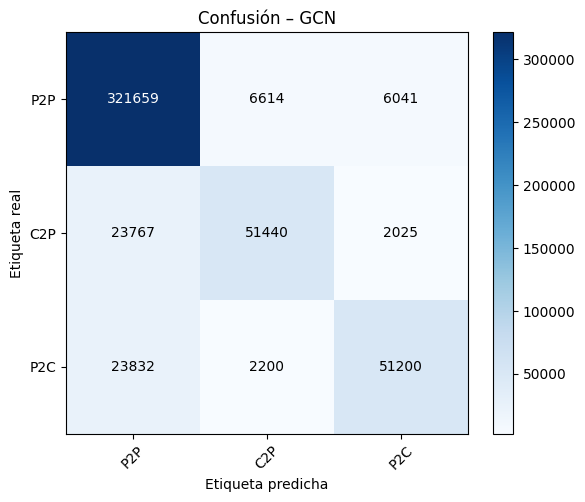

Matriz de confusión normalizada (%)


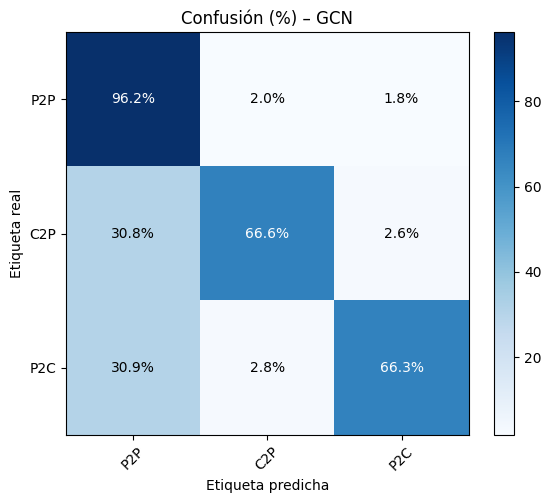

              precision    recall  f1-score   support

           0     0.8711    0.9621    0.9144    334314
           1     0.8537    0.6660    0.7483     77232
           2     0.8639    0.6629    0.7502     77232

    accuracy                         0.8681    488778
   macro avg     0.8629    0.7637    0.8043    488778
weighted avg     0.8672    0.8681    0.8622    488778



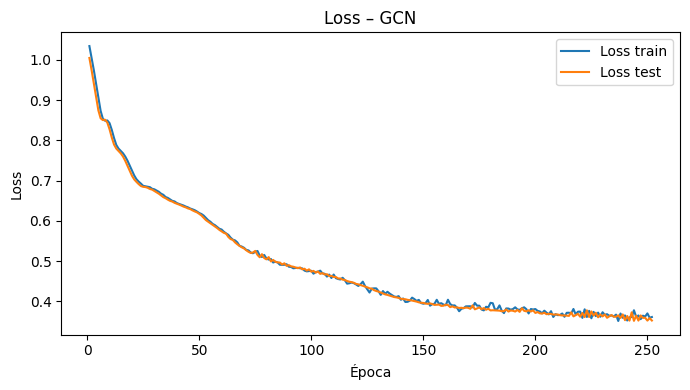

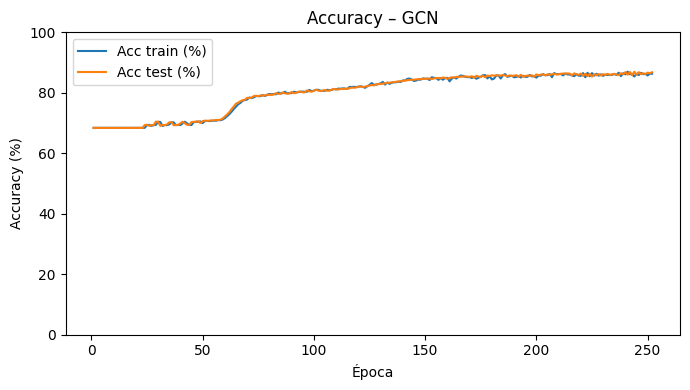


=== Training GraphSAGE ===
ep01 | loss_tr 1.0731 acc_tr 36.84% | loss_te 1.0082 acc_te 68.40%
ep10 | loss_tr 0.8227 acc_tr 68.43% | loss_te 0.8200 acc_te 68.47%
ep20 | loss_tr 0.7634 acc_tr 71.81% | loss_te 0.7437 acc_te 72.07%
ep30 | loss_tr 0.7064 acc_tr 74.54% | loss_te 0.6797 acc_te 74.93%
ep40 | loss_tr 0.6462 acc_tr 76.95% | loss_te 0.6143 acc_te 76.77%
ep50 | loss_tr 0.5961 acc_tr 79.10% | loss_te 0.5637 acc_te 79.00%
ep60 | loss_tr 0.5553 acc_tr 79.68% | loss_te 0.5277 acc_te 80.17%
ep70 | loss_tr 0.5268 acc_tr 80.21% | loss_te 0.4979 acc_te 80.91%
ep80 | loss_tr 0.4948 acc_tr 81.93% | loss_te 0.4784 acc_te 82.71%
ep90 | loss_tr 0.4901 acc_tr 82.54% | loss_te 0.4541 acc_te 83.25%
ep100 | loss_tr 0.4629 acc_tr 83.23% | loss_te 0.4362 acc_te 83.82%
ep110 | loss_tr 0.4553 acc_tr 83.61% | loss_te 0.4215 acc_te 84.43%
ep120 | loss_tr 0.4361 acc_tr 84.36% | loss_te 0.4094 acc_te 84.92%
ep130 | loss_tr 0.4263 acc_tr 84.56% | loss_te 0.3954 acc_te 85.54%
ep140 | loss_tr 0.4161 acc_tr 

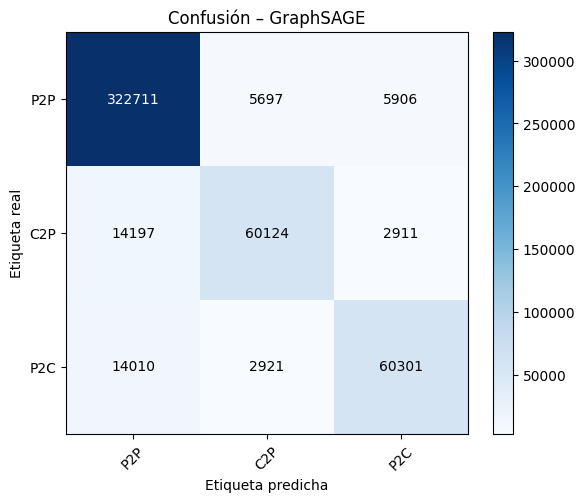

Matriz de confusión normalizada (%)


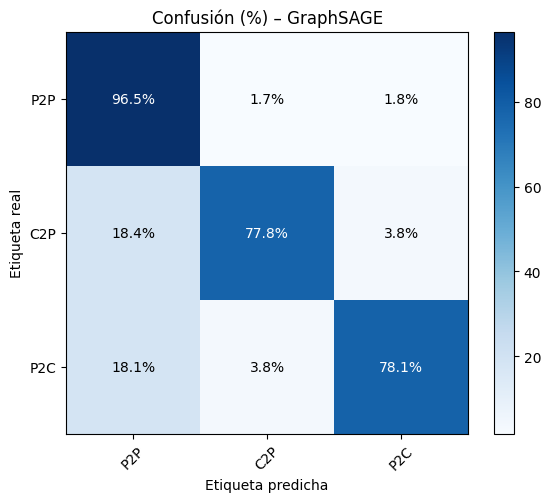

              precision    recall  f1-score   support

           0     0.9196    0.9653    0.9419    334314
           1     0.8746    0.7785    0.8238     77232
           2     0.8724    0.7808    0.8241     77232

    accuracy                         0.9066    488778
   macro avg     0.8889    0.8415    0.8632    488778
weighted avg     0.9051    0.9066    0.9046    488778



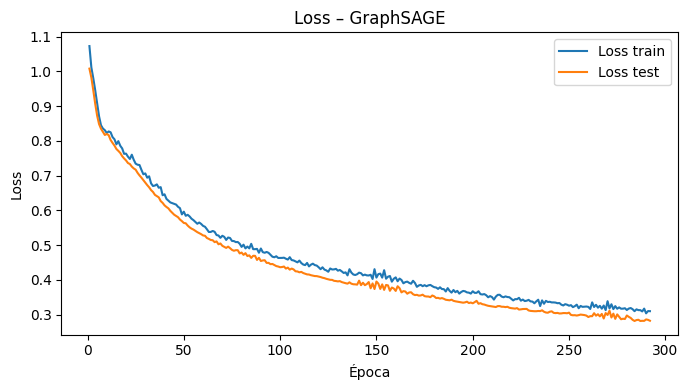

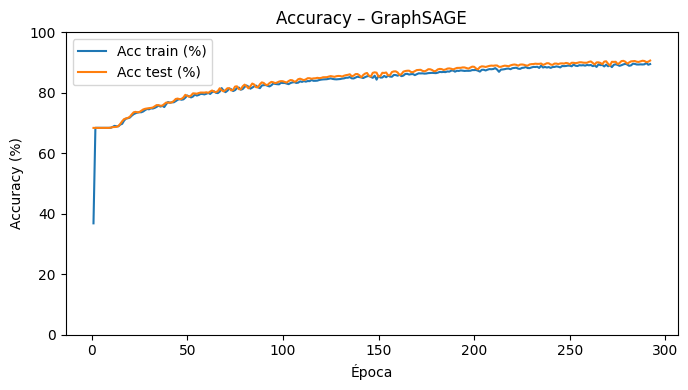


=== Training GAT ===
ep01 | loss_tr 1.1225 acc_tr 15.79% | loss_te 1.1109 acc_te 15.80%
ep10 | loss_tr 0.9662 acc_tr 68.42% | loss_te 0.9379 acc_te 68.40%
ep20 | loss_tr 0.8321 acc_tr 68.42% | loss_te 0.8352 acc_te 68.40%
ep30 | loss_tr 0.7828 acc_tr 68.96% | loss_te 0.7808 acc_te 69.52%
ep40 | loss_tr 0.7400 acc_tr 71.71% | loss_te 0.7283 acc_te 71.82%
ep50 | loss_tr 0.7079 acc_tr 72.71% | loss_te 0.6987 acc_te 73.07%
ep60 | loss_tr 0.6590 acc_tr 74.66% | loss_te 0.6482 acc_te 74.58%
ep70 | loss_tr 0.6175 acc_tr 76.25% | loss_te 0.6077 acc_te 76.95%
ep80 | loss_tr 0.6009 acc_tr 76.34% | loss_te 0.5875 acc_te 77.23%
ep90 | loss_tr 0.5752 acc_tr 77.98% | loss_te 0.5686 acc_te 78.39%
ep100 | loss_tr 0.5594 acc_tr 78.70% | loss_te 0.5658 acc_te 79.34%
ep110 | loss_tr 0.5498 acc_tr 78.87% | loss_te 0.5456 acc_te 79.57%
ep120 | loss_tr 0.5345 acc_tr 79.72% | loss_te 0.5370 acc_te 80.12%
ep130 | loss_tr 0.5096 acc_tr 80.05% | loss_te 0.5286 acc_te 80.44%
ep140 | loss_tr 0.4831 acc_tr 81.71%

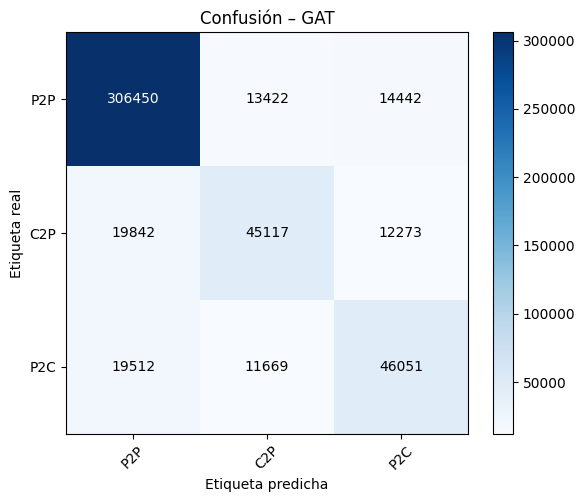

Matriz de confusión normalizada (%)


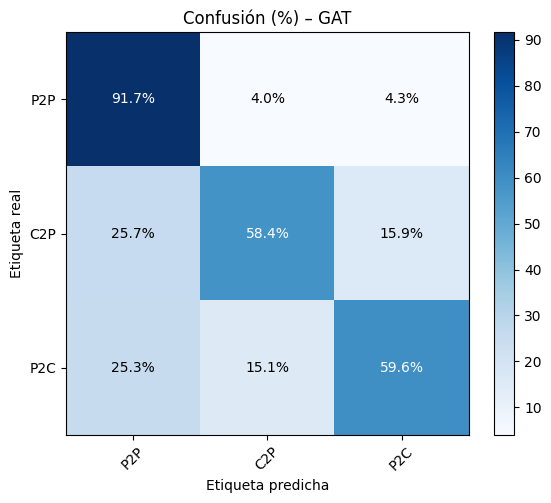

              precision    recall  f1-score   support

           0     0.8862    0.9167    0.9012    334314
           1     0.6426    0.5842    0.6120     77232
           2     0.6329    0.5963    0.6140     77232

    accuracy                         0.8135    488778
   macro avg     0.7206    0.6990    0.7091    488778
weighted avg     0.8077    0.8135    0.8101    488778



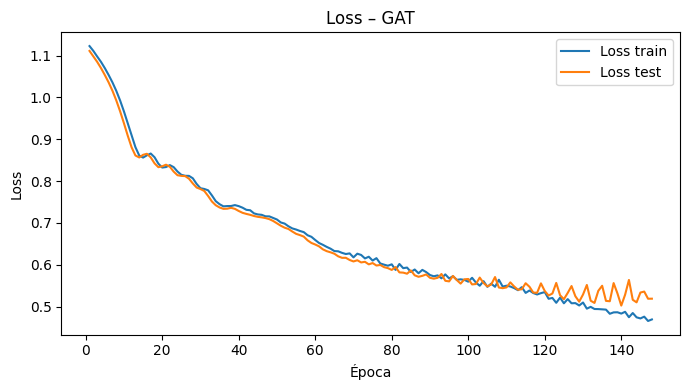

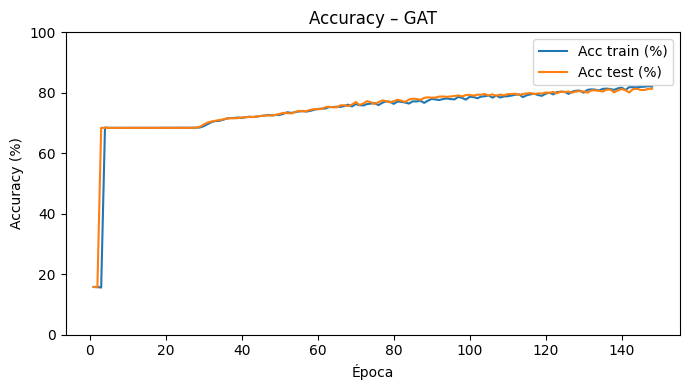

In [8]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 500
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()



### Caso 3: Con Random Neighbour Sampling

In [5]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}


In [6]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)
# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 459498.16it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=488776  test=488778
  clases train: {0: 334418, 2: 77179, 1: 77179}
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}


In [7]:
from collections import Counter
cnt = Counter(gnn.dgl_graph.edata['Relationship'][train_eids].tolist())
print(cnt)   # → algo como {0: 5 × 10⁶, 1: 8 × 10⁵, 2: 8 × 10⁵}


Counter({0: 534690, 2: 123676, 1: 123676})


AQUIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII


In [7]:
train_mask = gnn.dgl_graph.edata['train_mask']
test_mask = gnn.dgl_graph.edata['test_mask']

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")

TRAIN IDX: tensor([False, False, False,  ...,  True,  True,  True])
TEST IDX: tensor([False, False, False,  ..., False, False, False])
TRAIN NIDS: tensor([  25492,   27587,   38938,  ..., 1676597, 1676598, 1676599])
TEST NIDS: tensor([  39963,  141942,  146457,  ..., 1676579, 1676586, 1676587])


In [8]:
# Definir Dataloader y Sampler Training
sampler_train = dgl.dataloading.NeighborSampler([10, 10])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler_train, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([10,10])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler_test, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)

In [9]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler": GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler": GATSample
}

import tqdm


===== Entrenando GCN-Sampler =====


100%|██████████| 783/783 [00:09<00:00, 84.00it/s]


ep001 | loss_tr 0.4153 acc_tr 84.53% | loss_te 0.4200 acc_te 84.55%


100%|██████████| 783/783 [00:10<00:00, 71.72it/s]


ep005 | loss_tr 0.3145 acc_tr 88.85% | loss_te 0.3843 acc_te 86.33%


100%|██████████| 783/783 [00:10<00:00, 77.18it/s]


ep010 | loss_tr 0.3037 acc_tr 89.31% | loss_te 0.3649 acc_te 86.86%


100%|██████████| 783/783 [00:10<00:00, 76.85it/s]


🛑  Early-stop en época 15
              precision    recall  f1-score   support

           0     0.8588    0.9864    0.9182    134042
           1     0.9023    0.6144    0.7310     30735
           2     0.9076    0.6088    0.7288     30735

    accuracy                         0.8686    195512
   macro avg     0.8896    0.7366    0.7927    195512
weighted avg     0.8733    0.8686    0.8590    195512

Matriz de confusión normalizada (%)


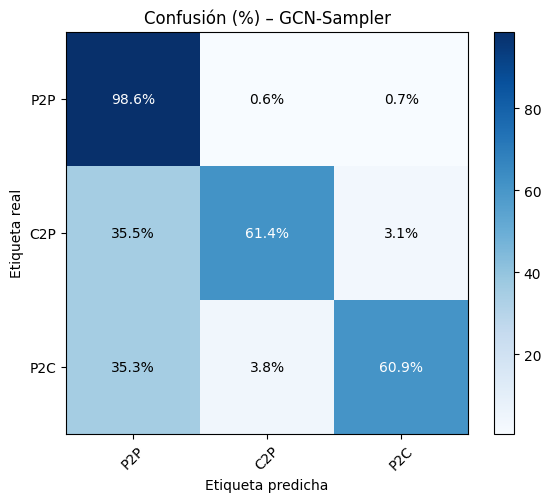

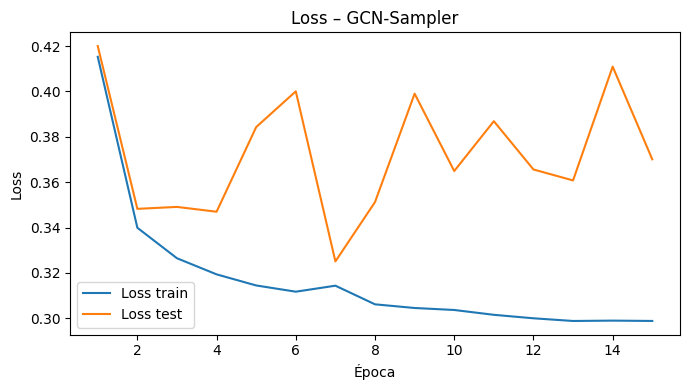

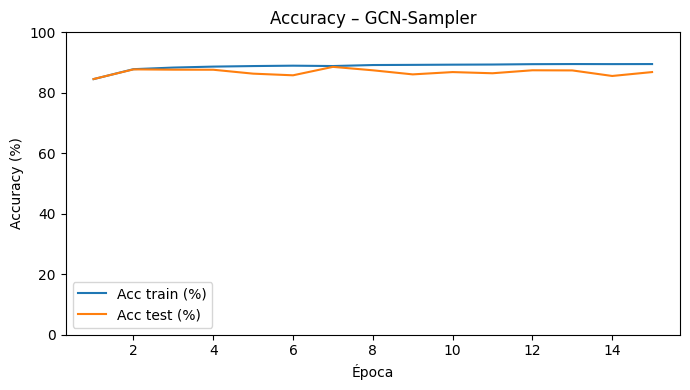

MAE = 0.1918 | R² = 0.4456

===== Entrenando SAGE-Sampler =====


  0%|          | 0/783 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 783/783 [00:10<00:00, 76.74it/s]


ep001 | loss_tr 0.4140 acc_tr 84.60% | loss_te 0.5774 acc_te 78.88%


100%|██████████| 783/783 [00:10<00:00, 76.27it/s]


ep005 | loss_tr 0.3164 acc_tr 88.75% | loss_te 0.3827 acc_te 86.04%


100%|██████████| 783/783 [00:10<00:00, 77.43it/s]


ep010 | loss_tr 0.3029 acc_tr 89.37% | loss_te 0.3507 acc_te 87.52%


100%|██████████| 783/783 [00:09<00:00, 79.12it/s]


ep015 | loss_tr 0.3007 acc_tr 89.42% | loss_te 0.3031 acc_te 89.31%


100%|██████████| 783/783 [00:09<00:00, 81.34it/s]


ep020 | loss_tr 0.2976 acc_tr 89.54% | loss_te 0.3156 acc_te 88.77%


100%|██████████| 783/783 [00:11<00:00, 70.59it/s]


🛑  Early-stop en época 23
              precision    recall  f1-score   support

           0     0.8932    0.9763    0.9329    134042
           1     0.8845    0.6959    0.7790     30735
           2     0.8704    0.7025    0.7775     30735

    accuracy                         0.8892    195512
   macro avg     0.8827    0.7916    0.8298    195512
weighted avg     0.8882    0.8892    0.8843    195512

Matriz de confusión normalizada (%)


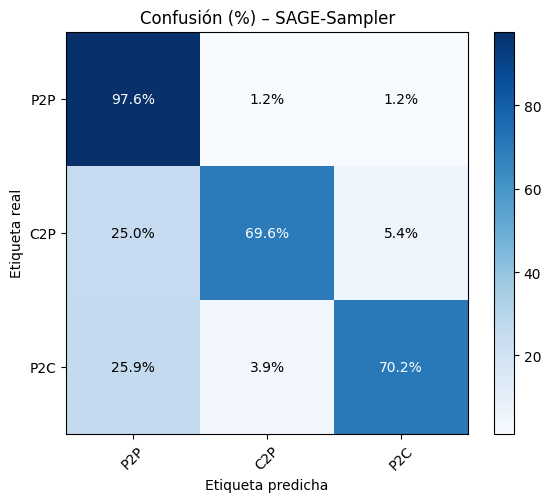

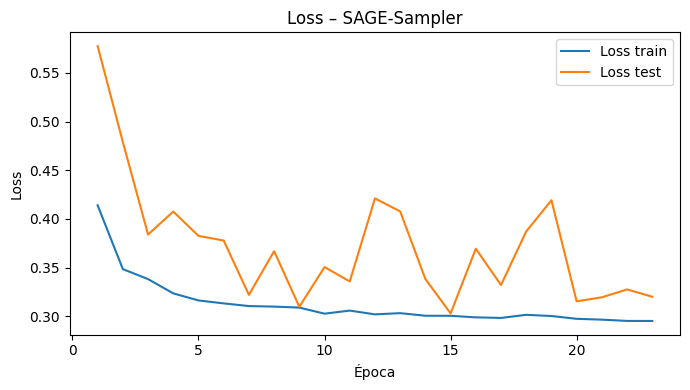

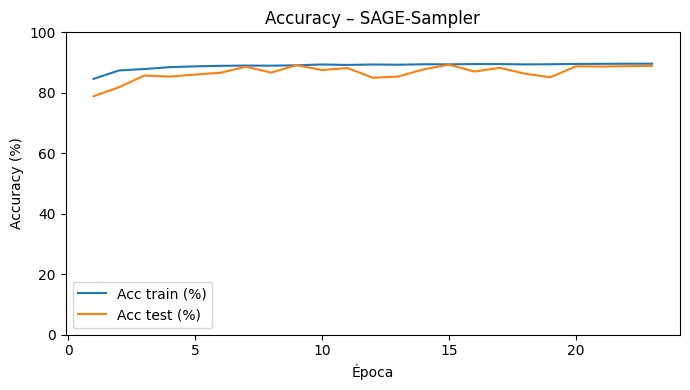

MAE = 0.1595 | R² = 0.5441

===== Entrenando GAT-Sampler =====


  0%|          | 0/783 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 783/783 [00:18<00:00, 42.15it/s]


ep001 | loss_tr 0.5272 acc_tr 81.21% | loss_te 0.4774 acc_te 83.18%


100%|██████████| 783/783 [00:18<00:00, 42.69it/s]


ep005 | loss_tr 0.3582 acc_tr 87.47% | loss_te 0.3926 acc_te 86.25%


100%|██████████| 783/783 [00:16<00:00, 46.86it/s]


ep010 | loss_tr 0.3405 acc_tr 88.15% | loss_te 0.3445 acc_te 88.06%


100%|██████████| 783/783 [00:18<00:00, 41.36it/s]


ep015 | loss_tr 0.3332 acc_tr 88.42% | loss_te 0.3567 acc_te 87.66%


100%|██████████| 783/783 [00:19<00:00, 41.14it/s]


ep020 | loss_tr 0.3308 acc_tr 88.48% | loss_te 0.3496 acc_te 87.83%


100%|██████████| 783/783 [00:20<00:00, 38.87it/s]


ep025 | loss_tr 0.3261 acc_tr 88.67% | loss_te 0.3310 acc_te 88.50%


100%|██████████| 783/783 [00:17<00:00, 43.72it/s]


ep030 | loss_tr 0.3230 acc_tr 88.81% | loss_te 0.3198 acc_te 89.00%


100%|██████████| 783/783 [00:17<00:00, 46.02it/s]


ep035 | loss_tr 0.3215 acc_tr 88.84% | loss_te 0.3269 acc_te 88.75%


100%|██████████| 783/783 [00:18<00:00, 42.53it/s]


🛑  Early-stop en época 38
              precision    recall  f1-score   support

           0     0.9121    0.9524    0.9318    134042
           1     0.8471    0.7291    0.7836     30735
           2     0.8051    0.7623    0.7831     30735

    accuracy                         0.8874    195512
   macro avg     0.8548    0.8146    0.8329    195512
weighted avg     0.8851    0.8874    0.8851    195512

Matriz de confusión normalizada (%)


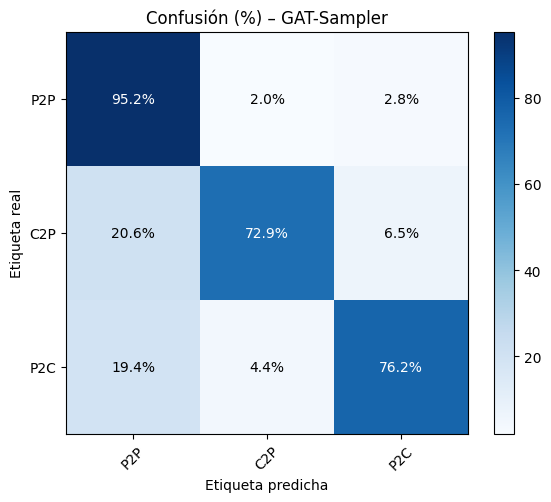

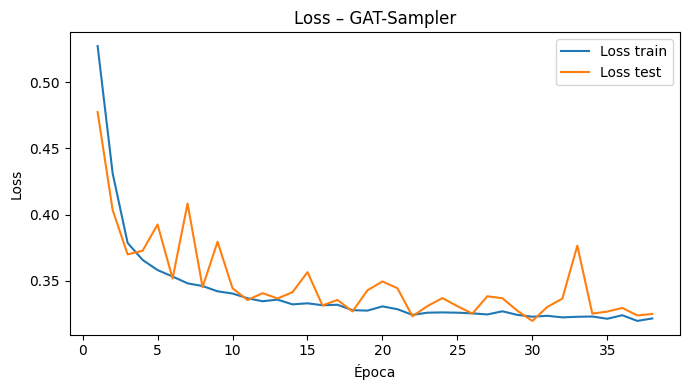

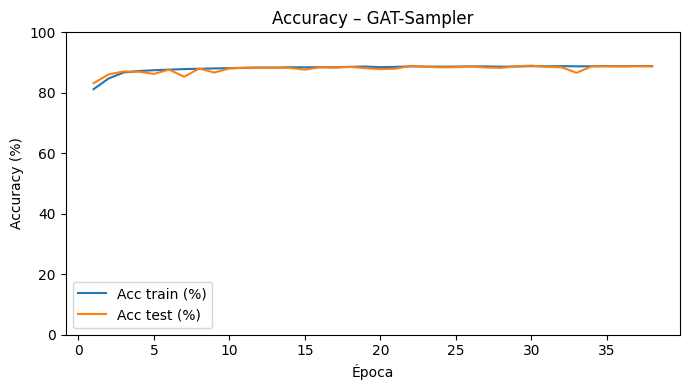

MAE = 0.1619 | R² = 0.5377


In [11]:
import tqdm, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    mean_absolute_error, r2_score
)

# ─── hiperparámetros ───────────────────────────────────────────────
in_feats   = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_dim = 64
emb_dim    = 32
n_classes  = 3
epochs     = 500
lr         = 1e-2
patience   = 8
device     = "cuda" if torch.cuda.is_available() else "cpu"

# ─── bucle sobre modelos ───────────────────────────────────────────
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, hidden_dim, emb_dim,
                  out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # almacenamos historial por época
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0         # early-stopping

    # ─── entrenamiento por época ────────────────────────────────
    for ep in range(1, epochs + 1):
        # ---- entrenamiento ------------------------------------
        model.train()
        loss_sum = corr = total = 0

        for input_nodes, output_graph, mfgs in tqdm.tqdm(
                train_dataloader):
            mfgs     = list(mfgs)
            edge_ids = output_graph.edata[dgl.EID].to(device)
            inputs        = mfgs[0].srcdata["feat"].to(device)
            y        = gnn.dgl_graph.edata["Relationship"][edge_ids].long().to(device)

            h       = model.encode(mfgs, inputs)               # (N_batch, emb_dim)
            logits  = model.decodeMLP(output_graph, h)    # (E_batch, 3)

            loss = F.cross_entropy(logits, y)
            optim.zero_grad();  loss.backward();  optim.step()

            # métrica de accuracy en batch
            pred = logits.argmax(1)
            corr += (pred == y).sum().item()
            total += len(y)
            loss_sum += loss.item() * len(y)

        loss_tr = loss_sum / total
        acc_tr  = 100 * corr / total

        # ---- validación ---------------------------------------
        model.eval()
        loss_sum = corr = total = 0
        preds_all, labels_all = [], []

        with torch.no_grad():
            for input_nodes, output_graph, mfgs in test_dataloader:
                mfgs     = list(mfgs)
                edge_ids = output_graph.edata[dgl.EID].to(device)
                inputs   = mfgs[0].srcdata["feat"].to(device)
                y        = gnn.dgl_graph.edata["Relationship"][edge_ids].long().to(device)

                h_val    = model.encode(mfgs, inputs)
                logits = model.decodeMLP(output_graph, h_val)

                loss_sum += F.cross_entropy(logits, y).item() * len(y)
                pred = logits.argmax(1)

                corr  += (pred == y).sum().item()
                total += len(y)

                preds_all.append(pred.cpu())
                labels_all.append(y.cpu())

        loss_te = loss_sum / total
        acc_te  = 100 * corr / total

        # ---- historial + early-stopping -----------------------
        hist["loss_tr"].append(loss_tr);  hist["loss_te"].append(loss_te)
        hist["acc_tr"].append(acc_tr);    hist["acc_te"].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {ep}")
                break

        if ep % 5 == 0 or ep == 1:
            print(f"ep{ep:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ─── evaluación final (con mejor modelo) ─────────────────────
    model.load_state_dict(best_state)
    preds = torch.cat(preds_all)
    truth = torch.cat(labels_all)

    cm = confusion_matrix(truth, preds)
    print(classification_report(truth, preds, digits=4))

    plot_confusion_matrix_2(
        cm,
        classes=["P2P", "C2P", "P2C"],
        normalize=True,
        title=f"Confusión (%) – {name}",
        fname=f"img/resultados/gnn/end-to-end/{name.lower()}/cm_{name.lower()}",
        save=True  # cambia a False si no quieres guardarla
    )

    # ─── gráficos de historial ──────────────────────────────────
    ep_axis = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["loss_tr"], label="Loss train")
    plt.plot(ep_axis, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["acc_tr"], label="Acc train (%)")
    plt.plot(ep_axis, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    # ─── métricas numéricas tipo MAE / R² (opcional) ─────────────
    mae = mean_absolute_error(truth, preds)
    r2  = r2_score(truth, preds)
    print(f"MAE = {mae:.4f} | R² = {r2:.4f}")


### Caso 5: Crear represetaciones de los nodos desde 0

In [5]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [6]:
print("Total aristas:", gnn.dgl_graph.num_edges())
print("Training set:", train_m.sum().item())
print("Test set:", test_m.sum().item())
print("Intersección:", (train_m & test_m).sum().item())  # Debe ser 0



NameError: name 'gnn' is not defined

In [7]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)


# 64 features con poca varianza inicial
# gnn.add_random_features(dim=64, std=0.05, seed=42, mode="minmax")

# gnn.add_random_features(dim=64, std=0.05, seed=42, mode="zscore")

gnn.add_random_features(dim=64, std=0.05, seed=42, mode="uniform")


# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 481534.34it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[add_random_features] feat ← (401308, 64)  |  mode=uniform
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}


In [12]:
from torch import tensor

# contar la cantidad de ocurrencias por clase en las etiquetas de entrenamiento
train_labels = labels[train_m]
counts = torch.bincount(train_labels, minlength=n_classes)

# peso inverso a la frecuencia (opcionalmente se puede normalizar)
class_weights = 1.0 / counts.float()
class_weights = class_weights / class_weights.sum() * n_classes  # opcional: normalizar

class_weights = class_weights.to(device)



=== Training GCN ===
ep01 | loss_tr 1.0059 acc_tr 68.37% | loss_te 0.8596 acc_te 68.56%
ep10 | loss_tr 0.5956 acc_tr 70.90% | loss_te 0.5951 acc_te 71.04%
ep20 | loss_tr 0.5758 acc_tr 70.22% | loss_te 0.5641 acc_te 70.28%
ep30 | loss_tr 0.5452 acc_tr 73.39% | loss_te 0.5364 acc_te 72.87%
ep40 | loss_tr 0.5386 acc_tr 77.62% | loss_te 0.5363 acc_te 70.31%
ep50 | loss_tr 0.5048 acc_tr 78.10% | loss_te 0.5044 acc_te 80.89%
ep60 | loss_tr 0.4752 acc_tr 82.91% | loss_te 0.4593 acc_te 85.48%
ep70 | loss_tr 0.4876 acc_tr 81.57% | loss_te 0.4565 acc_te 84.56%
ep80 | loss_tr 0.4236 acc_tr 86.39% | loss_te 0.4101 acc_te 87.51%
ep90 | loss_tr 0.4312 acc_tr 86.34% | loss_te 0.4703 acc_te 83.91%
🛑  Early stop en época 95
Matriz de confusión sin normalizar


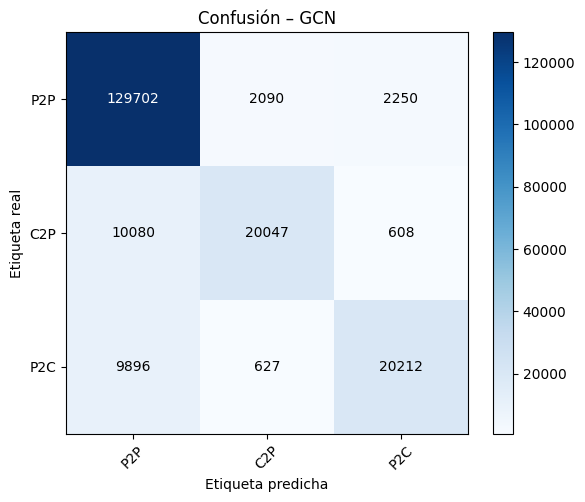

Matriz de confusión normalizada (%)


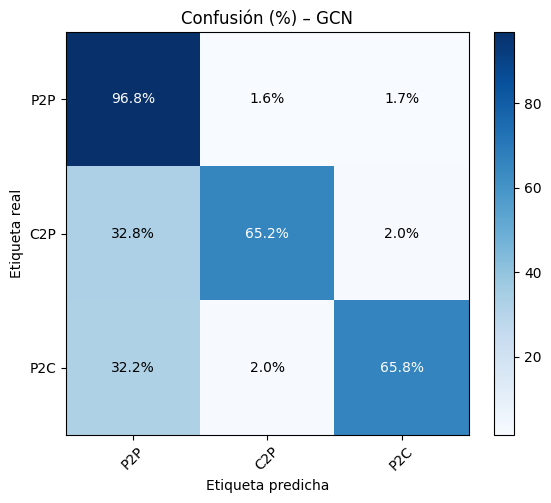

              precision    recall  f1-score   support

           0     0.8665    0.9676    0.9143    134042
           1     0.8806    0.6523    0.7494     30735
           2     0.8761    0.6576    0.7513     30735

    accuracy                         0.8693    195512
   macro avg     0.8744    0.7592    0.8050    195512
weighted avg     0.8703    0.8693    0.8628    195512



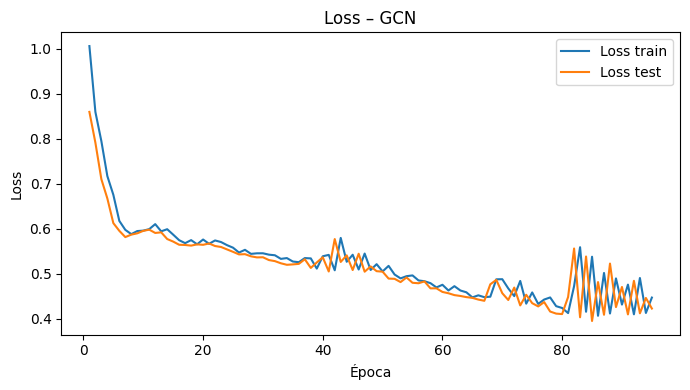

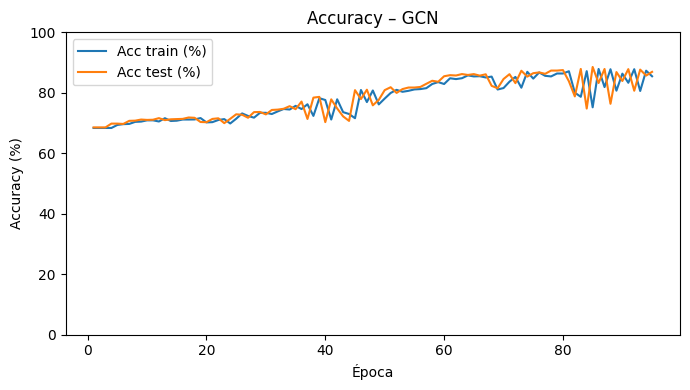


=== Training GraphSAGE ===
ep01 | loss_tr 1.3316 acc_tr 16.08% | loss_te 0.9817 acc_te 68.59%
ep10 | loss_tr 0.8596 acc_tr 68.37% | loss_te 0.8434 acc_te 68.56%
ep20 | loss_tr 0.8438 acc_tr 68.37% | loss_te 0.8410 acc_te 68.56%
ep30 | loss_tr 0.8353 acc_tr 68.37% | loss_te 0.8379 acc_te 68.56%
🛑  Early stop en época 32
Matriz de confusión sin normalizar


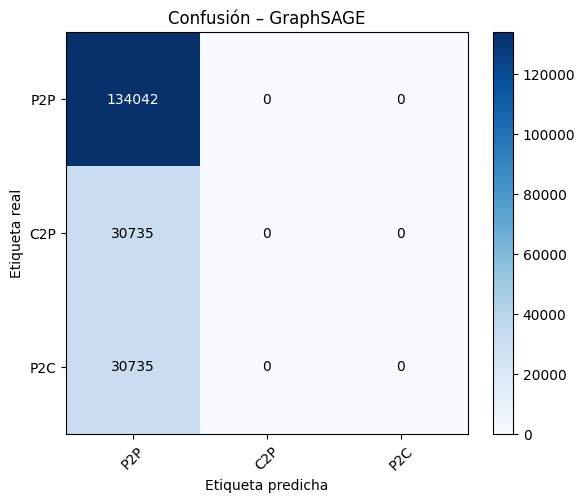

Matriz de confusión normalizada (%)


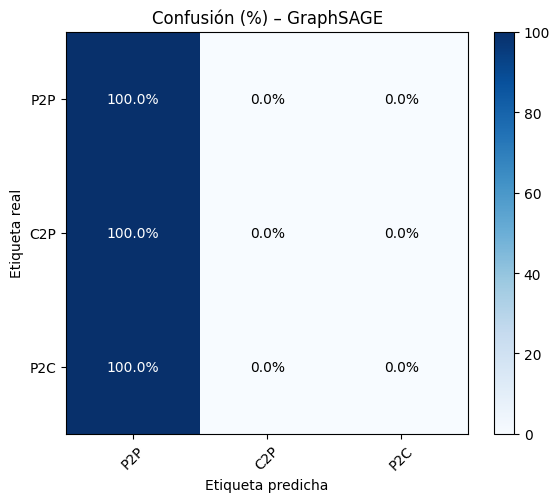

              precision    recall  f1-score   support

           0     0.6856    1.0000    0.8135    134042
           1     0.0000    0.0000    0.0000     30735
           2     0.0000    0.0000    0.0000     30735

    accuracy                         0.6856    195512
   macro avg     0.2285    0.3333    0.2712    195512
weighted avg     0.4700    0.6856    0.5577    195512



/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

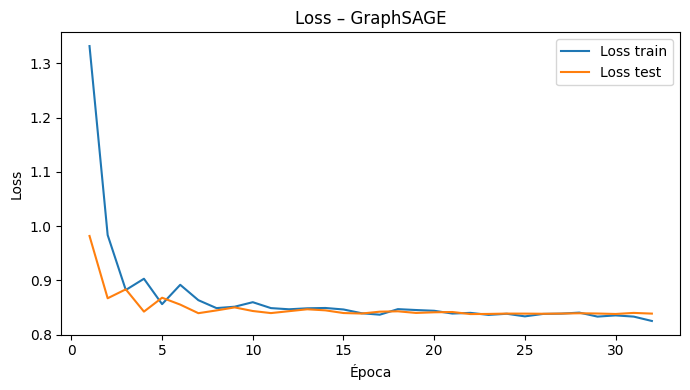

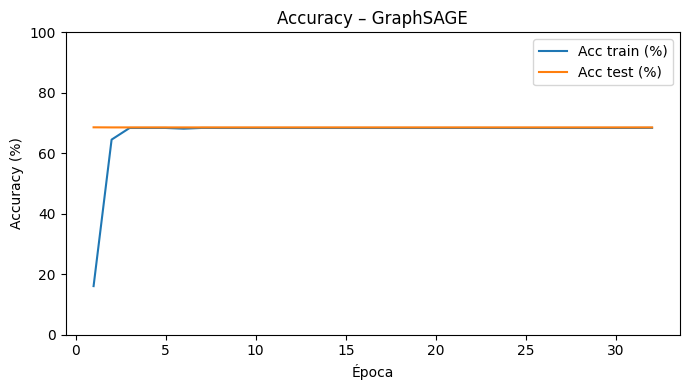


=== Training GAT ===
ep01 | loss_tr 0.9598 acc_tr 68.39% | loss_te 0.8624 acc_te 68.56%
ep10 | loss_tr 0.8057 acc_tr 68.37% | loss_te 0.8291 acc_te 68.56%
ep20 | loss_tr 0.6014 acc_tr 76.36% | loss_te 2.0716 acc_te 15.73%
🛑  Early stop en época 21
Matriz de confusión sin normalizar


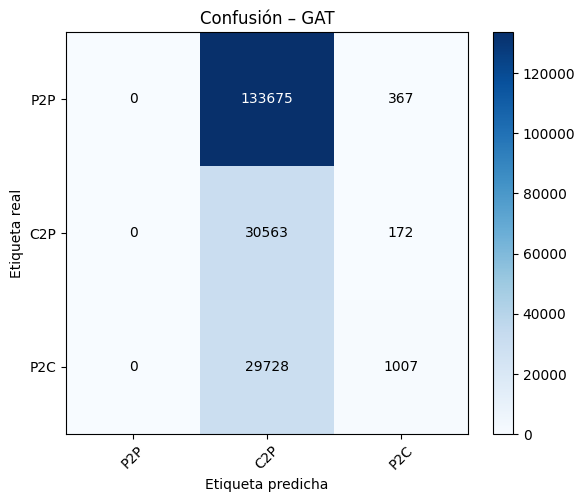

Matriz de confusión normalizada (%)


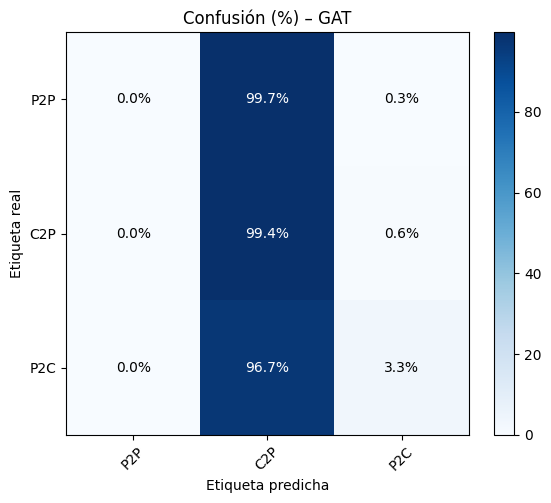

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    134042
           1     0.1576    0.9944    0.2720     30735
           2     0.6514    0.0328    0.0624     30735

    accuracy                         0.1615    195512
   macro avg     0.2696    0.3424    0.1115    195512
weighted avg     0.1272    0.1615    0.0526    195512



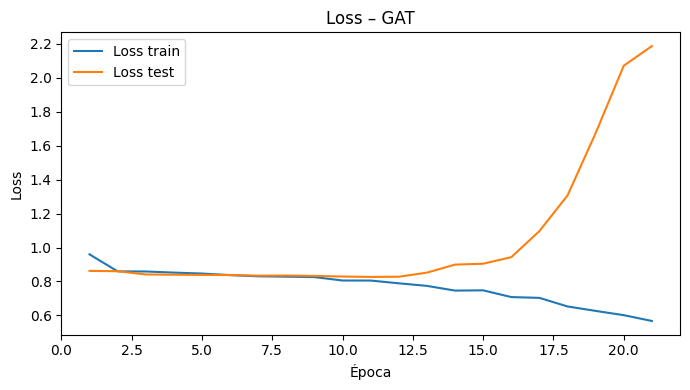

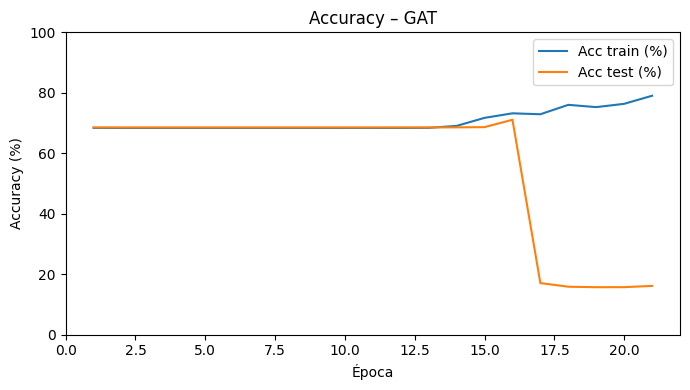

In [9]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 200
lr        = 0.01
patience  = 10           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        # loss   = F.cross_entropy(logits[train_m], labels[train_m], weight=class_weights)

        
        opt.zero_grad() 
        loss.backward()
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            # loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m], weight=class_weights)
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


Posibles arreglos:
Diferencia de arquitectura.

    GCN usa la matriz de adyacencia simétrica → capta información global
    rápidamente aun con features aleatorios.

    GraphSAGE (mean) y GAT agregan solamente vecinos; al inicio todos
    los nodos tienen casi el mismo vector aleatorio normalizado
    ⇒ el primer paso de agregación produce embeddings muy parecidos en todas
    partes ⇒ el gradiente se vuelve más pequeño que en GCN y cuesta salir del
    mínimo “todo-P2P”.

Falta de self-loop en SAGE y GAT.
Al no sumar la propia característica el “mensaje” inicial puede diluirse
aún más. (GCN lo incorpora por defecto en tu código).

Función de pérdida sin ponderar.
F.cross_entropy default = ponderación uniforme → la clase mayoritaria
domina.


=== GCN ===
ep001 | loss_tr 1.1307 acc_tr 42.33% | loss_te 1.0521 acc_te 73.02%
ep020 | loss_tr 0.8276 acc_tr 48.23% | loss_te 0.9580 acc_te 21.98%
ep040 | loss_tr 0.7760 acc_tr 62.21% | loss_te 0.8601 acc_te 32.38%
ep060 | loss_tr 0.7224 acc_tr 77.24% | loss_te 0.7794 acc_te 84.84%
ep080 | loss_tr 0.6484 acc_tr 81.62% | loss_te 0.6838 acc_te 90.04%
ep100 | loss_tr 0.5881 acc_tr 79.93% | loss_te 0.6272 acc_te 91.53%
ep120 | loss_tr 0.5303 acc_tr 87.15% | loss_te 0.5897 acc_te 93.10%
Matriz de confusión sin normalizar


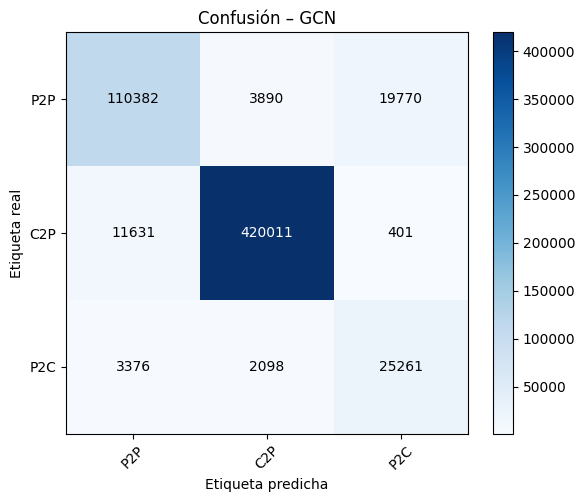

Matriz de confusión normalizada (%)


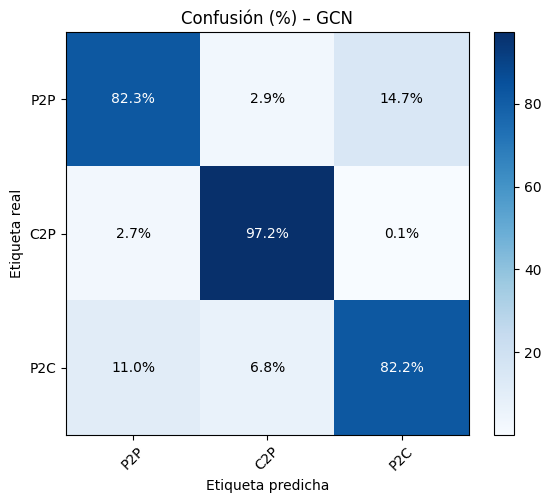

              precision    recall  f1-score   support

           0     0.8803    0.8235    0.8510    134042
           1     0.9859    0.9722    0.9790    432043
           2     0.5560    0.8219    0.6633     30735

    accuracy                         0.9310    596820
   macro avg     0.8074    0.8725    0.8311    596820
weighted avg     0.9401    0.9310    0.9340    596820



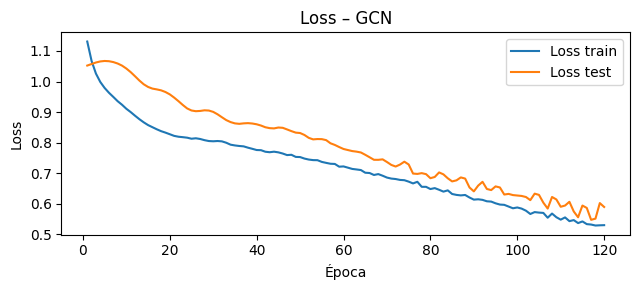

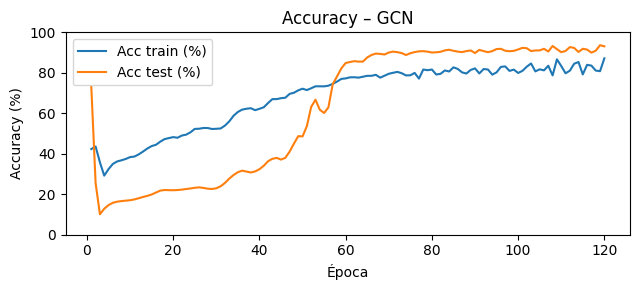


=== GraphSAGE ===
ep001 | loss_tr 1.1104 acc_tr 35.91% | loss_te 1.1090 acc_te 21.91%
🛑  Early-stop en época 11
Matriz de confusión sin normalizar


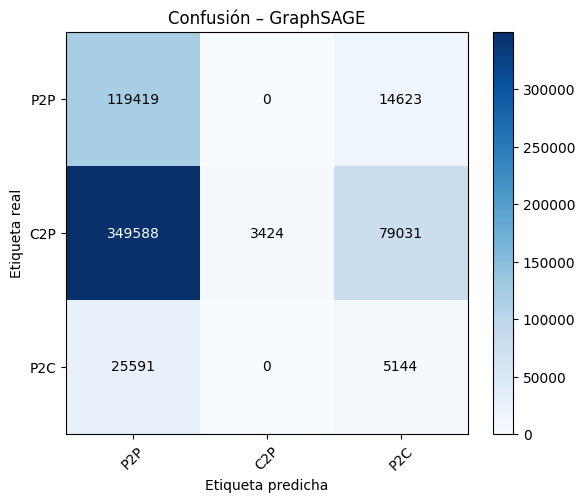

Matriz de confusión normalizada (%)


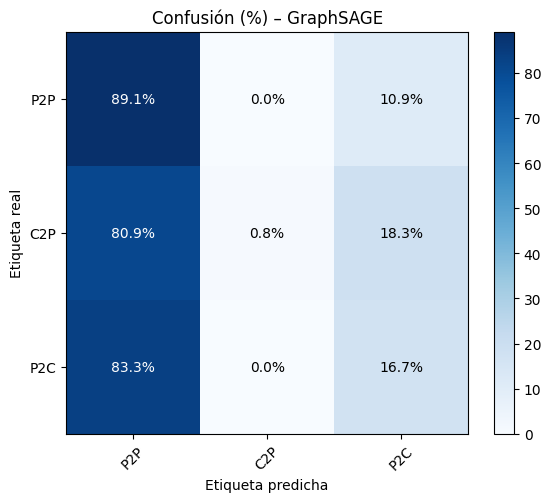

              precision    recall  f1-score   support

           0     0.2414    0.8909    0.3799    134042
           1     1.0000    0.0079    0.0157    432043
           2     0.0521    0.1674    0.0794     30735

    accuracy                         0.2144    596820
   macro avg     0.4312    0.3554    0.1584    596820
weighted avg     0.7808    0.2144    0.1008    596820



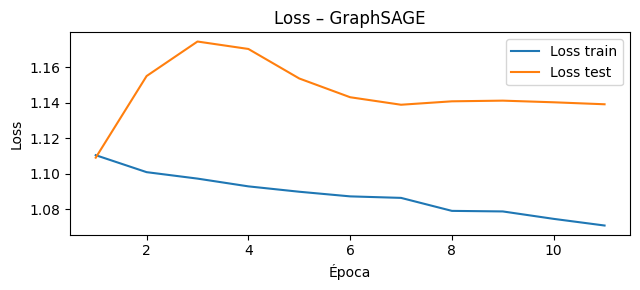

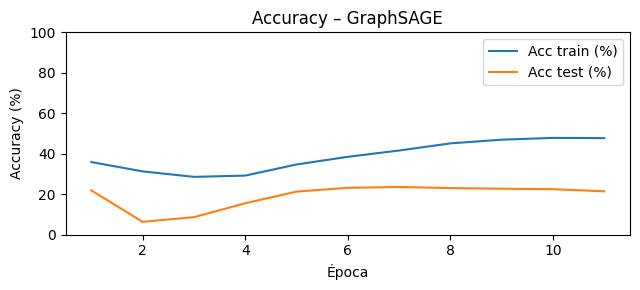


=== GAT ===
ep001 | loss_tr 1.1193 acc_tr 10.89% | loss_te 1.1246 acc_te  5.15%
ep020 | loss_tr 1.0637 acc_tr 62.86% | loss_te 1.0834 acc_te 58.88%
ep040 | loss_tr 0.9308 acc_tr 70.91% | loss_te 0.9125 acc_te 72.39%
🛑  Early-stop en época 56
Matriz de confusión sin normalizar


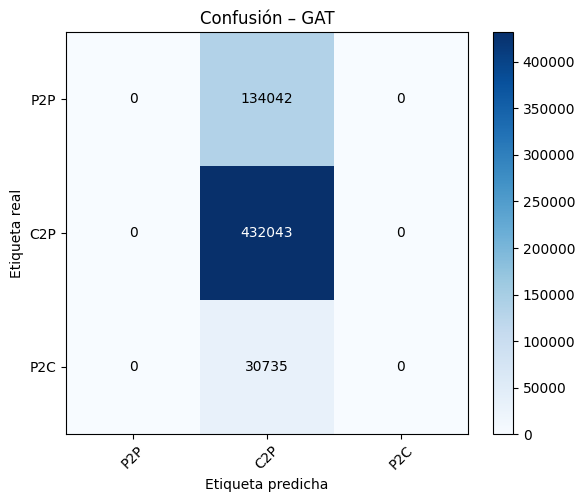

Matriz de confusión normalizada (%)


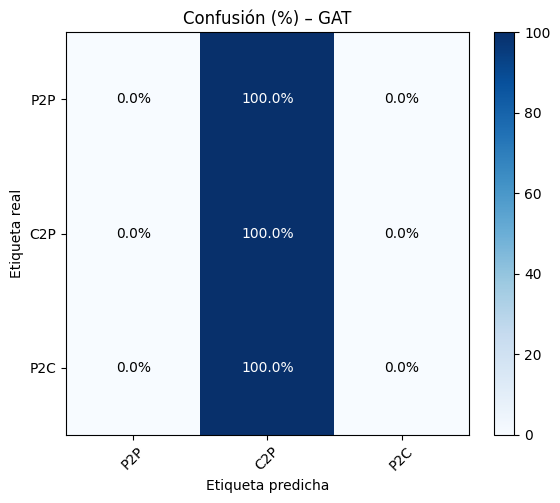

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    134042
           1     0.7239    1.0000    0.8398    432043
           2     0.0000    0.0000    0.0000     30735

    accuracy                         0.7239    596820
   macro avg     0.2413    0.3333    0.2799    596820
weighted avg     0.5240    0.7239    0.6080    596820



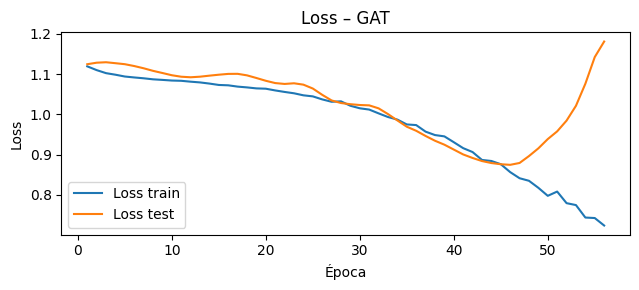

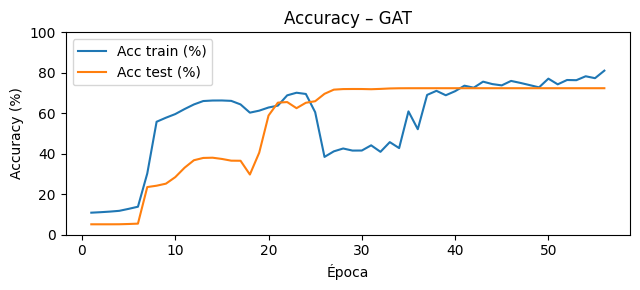

In [14]:
# version arreglada por chatgpt

import torch, torch.nn.functional as F
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# ─── configuración general ─────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
g        = gnn.dgl_graph
g = dgl.add_self_loop(g)
g = g.to(device)

x        = g.ndata['feat'].to(device)
y        = g.edata['Relationship'].long().to(device)
tr, te   = g.edata['train_mask'], g.edata['test_mask']

# pesos inversos al nº de ejemplos por clase (0,1,2)
cnt      = Counter(y[tr].tolist())
w_cls    = torch.tensor([1/cnt[i] for i in range(3)], device=device, dtype=torch.float)

epochs   = 120
lr       = 1e-3          # algo más bajo ayuda a SAGE/GAT
patience = 10

# ─── entrenamiento por cada arquitectura ───────────────────────────
for name, Model in models.items():          # GCN, GraphSAGE, GAT …
    print(f"\n=== {name} ===")
    model = Model(x.shape[1], 64, 32, out_feats_mlp=3).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    hist  = {'ltr':[], 'lte':[], 'atr':[], 'ate':[]}
    best_loss, wait, best_w = 1e9, 0, None

    for ep in range(1, epochs + 1):
        # -------- train --------
        model.train()
        logits = model.decodeMLP(g, model.encode(g, x))
        loss   = F.cross_entropy(logits[tr], y[tr], weight=w_cls)

        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            pred_tr = logits[tr].argmax(1)
            acc_tr  = (pred_tr == y[tr]).float().mean().item()*100

        # -------- test ---------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, x))
            loss_te  = F.cross_entropy(logits_t[te], y[te], weight=w_cls)
            pred_te  = logits_t[te].argmax(1)
            acc_te   = (pred_te == y[te]).float().mean().item()*100

        # -------- histórico ----
        hist['ltr'].append(loss.item()) ; hist['lte'].append(loss_te.item())
        hist['atr'].append(acc_tr)       ; hist['ate'].append(acc_te)

        # -------- early-stop ----
        if loss_te < best_loss - 1e-4:
            best_loss, wait, best_w = loss_te, 0, {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {ep}")
                break

        if ep % 20 == 0 or ep == 1:
            print(f"ep{ep:03d} | loss_tr {loss:.4f} acc_tr {acc_tr:5.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:5.2f}%")

    # ─── evaluación final ───────────────────────────────────────────
    model.load_state_dict(best_w, strict=False)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, x))
        preds_best  = logits_best[te].argmax(1).cpu()
        truth       = y[te].cpu()

    # matriz de confusión
    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")
    print(classification_report(truth, preds_best, digits=4))

    # curvas
    ep_axis = range(1, len(hist['ltr'])+1)
    plt.figure(figsize=(6.5,3))
    plt.plot(ep_axis, hist['ltr'], label='Loss train')
    plt.plot(ep_axis, hist['lte'], label='Loss test')
    plt.xlabel('Época'); plt.ylabel('Loss'); plt.title(f'Loss – {name}')
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6.5,3))
    plt.plot(ep_axis, hist['atr'], label='Acc train (%)')
    plt.plot(ep_axis, hist['ate'], label='Acc test (%)')
    plt.xlabel('Época'); plt.ylabel('Accuracy (%)'); plt.ylim(0,100)
    plt.title(f'Accuracy – {name}')
    plt.legend(); plt.tight_layout(); plt.show()


### Caso 4: Utilizando metodo de sampling Cluster batch normalization

parte el grafo en K clusters disjuntos y cada
mini-batch es todo un cluster (no un bloque‐vecinos).

|                              | NeighborSampler (antes)                      | ClusterGCNSampler (ahora)                                                                 |
| ---------------------------- | -------------------------------------------- | ----------------------------------------------------------------------------------------- |
| lo que devuelve `DataLoader` | `(input_nodes, pair_graph, blocks)`          | **un único subgrafo** `subg`                                                              |
| cómo llamo al `encode`       | `model.encode(blocks, x)` (lista de bloques) | `model.encode([subg], x)` **o** `model.encode(subg, x)` si tu `encode` acepta un DGLGraph |


In [5]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}


In [6]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.5, seed=42)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:01, 468188.44it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=488776  test=488778
  clases train: {0: 334418, 2: 77179, 1: 77179}


In [18]:
import os
if os.path.exists("cluster_gcn.pkl"):
    os.remove("cluster_gcn.pkl")


In [19]:

num_parts = 1000                       # ajusta tamaño de cluster
device    = "cuda" if torch.cuda.is_available() else "cpu"

# ① sampler
sampler = dgl.dataloading.ClusterGCNSampler(
            gnn.dgl_graph, num_parts,
            prefetch_ndata=['feat'],
            prefetch_edata=['Relationship', 'train_mask', 'test_mask']
            )

# ② índices de clusters = 0 … (num_parts-1)
cluster_ids = torch.arange(num_parts)

# ③ DataLoader de entrenamiento  (shufle = True)
train_loader = dgl.dataloading.DataLoader(
        gnn.dgl_graph, cluster_ids, sampler,
        batch_size=1, shuffle=True, drop_last=False, device=device)

# ④ DataLoader de test             (sin barajar)
test_loader  = dgl.dataloading.DataLoader(
        gnn.dgl_graph, cluster_ids, sampler,
        batch_size=1, shuffle=False, drop_last=False, device=device)


Convert a graph into a bidirected graph: 0.029 seconds, peak memory: 15.762 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 15.762 GB
Metis partitioning: 2.368 seconds, peak memory: 15.762 GB


[03:21:20] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 401308 nodes and 1676600 edges into 5000 parts and get 733627 edge cuts


Cada iteración entrega subg, un subgrafo que contiene todos los
nodos y aristas de un cluster.

In [ ]:
from tqdm.auto import tqdm
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ─── hiper-parámetros ──────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata['feat'].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 50
lr        = 1e-3
patience  = 40               # early-stopping
n_classes = 3

# ─── loop sobre modelos ────────────────────────────────────────────
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, 64, 32, out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # historial
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0

    for epoch in range(1, epochs + 1):

        # ── TRAIN ───────────────────────────────────────────────────
        model.train()
        loss_sum = corr = tot = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d}", leave=False)
        for subg in pbar:                    # subg = grafo de un cluster
            if subg.num_edges() == 0:
                continue 
            subg = subg.to(device)
            x    = subg.ndata['feat'].float()
            y    = subg.edata['Relationship'].long()
            m    = subg.edata['train_mask'].bool()

            h      = model.encode(subg, x)          # <- nota: grafo completo
            logits = model.decodeMLP(subg, h)       # (E_cluster, 3)

            loss = F.cross_entropy(logits[m], y[m])

            optim.zero_grad()
            loss.backward()
            optim.step()

            # métrica batch
            loss_sum += loss.item() * m.sum().item()
            pred      = logits[m].argmax(1)
            corr     += (pred == y[m]).sum().item()
            tot      += m.sum().item()

        loss_tr = loss_sum / tot
        acc_tr  = 100 * corr / tot

        # ── TEST ────────────────────────────────────────────────────
        model.eval()
        loss_sum = corr = tot = 0
        preds_all, truth_all = [], []

        with torch.no_grad():
            for subg in test_loader:
                subg = subg.to(device)
                x    = subg.ndata['feat'].float()
                y    = subg.edata['Relationship'].long()
                m    = subg.edata['test_mask'].bool()

                h      = model.encode(subg, x)
                logits = model.decodeMLP(subg, h)

                loss_sum += F.cross_entropy(logits[m], y[m]).item() * m.sum().item()
                pred      = logits[m].argmax(1)

                corr += (pred == y[m]).sum().item()
                tot  += m.sum().item()
                preds_all.append(pred.cpu())
                truth_all.append(y[m].cpu())

        loss_te = loss_sum / tot
        acc_te  = 100 * corr / tot

        # ── historial + early-stopping ─────────────────────────────
        hist['loss_tr'].append(loss_tr);  hist['loss_te'].append(loss_te)
        hist['acc_tr'].append(acc_tr);    hist['acc_te'].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {epoch}")
                break

        if epoch % 5 == 0 or epoch == 1:
            print(f"ep{epoch:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ─── evaluación final ──────────────────────────────────────────
    if best_state is None:                      # por si nunca mejoró
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    preds = torch.cat(preds_all)
    truth = torch.cat(truth_all)

    cm = confusion_matrix(truth, preds)
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=False, title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=True,  title=f"Confusión (%) – {name}")
    print(classification_report(truth, preds, digits=4))

    # ─── gráficos de historial ─────────────────────────────────────
    ep_axis = range(1, len(hist['loss_tr']) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['loss_tr'], label="Loss train")
    plt.plot(ep_axis, hist['loss_te'], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss")
    plt.title(f"Curva de Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['acc_tr'], label="Acc train (%)")
    plt.plot(ep_axis, hist['acc_te'], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Curva de Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


In [27]:
from collections import Counter
tot = Counter(); tr = Counter(); te = Counter()

for sg in train_loader:             # lo que ve el encoder
    y = sg.edata['Relationship'][ sg.edata['train_mask'] ].tolist()
    tr.update(y)
for sg in test_loader:
    y = sg.edata['Relationship'][ sg.edata['test_mask'] ].tolist()
    te.update(y)

tot.update( gnn.dgl_graph.edata['Relationship'].tolist() )

print("GLOBAL :", tot)
print("TRAIN  :", tr)
print("TEST   :", te)


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


GLOBAL : Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
TRAIN  : Counter({0: 32702, 1: 31636, 2: 31636})
TEST   : Counter({0: 33258, 2: 31417, 1: 31417})
